In [1]:
import json
import pandas as pd
import time
import ccy 
from tqdm import tqdm_notebook as tqdm
import collections
from collections import Counter
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt

import operator

import urllib.request

import seaborn as sns

In [2]:
from ripple_api import RippleDataAPIClient,RippleRPCClient
api = RippleDataAPIClient('https://data.ripple.com')
rpc = RippleRPCClient('http://s1.ripple.com:51234/')

# 0. Data

Read the data, run only once 

In [ ]:
df = pd.read_csv("../data/transactions/ripple-transactions-jan-2013-dec-2016.csv")

In [4]:
df.head()

,Unnamed: 0,hash,sender,receiver,currency,amount,ledger,sourceTag,DestinationTag,9,10
0,0,5C0504B229CD8EE803B01D78868B8F4B595D8B1D03636B...,rfe8yiZUymRPx35BEwGjhfkaLmgNsTytxT,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,XRP,0.1,7227428,NaN,NaN,1,1402920660
1,1,56022C64D29974C116591563DC8A80547907BE38EEB134...,rfe8yiZUymRPx35BEwGjhfkaLmgNsTytxT,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,XRP,0.1,7224947,NaN,NaN,1,1402908860
2,2,CCA2EB48BC106C7F4692BF71819EC236C9E09E37BCF38C...,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,rhjyoR8rpLMKM47pUgTjdNuVDJ1CrYYBwT,XRP,2000.0,5541569,NaN,NaN,1,1394924250
3,3,423708E30D94335FE2858C11B3D57390669A20FCE6C485...,rMTzGg7nPPEMJthjgEBfiPZGoAM7MEVa1r,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,XRP,2020.0,3333190,NaN,NaN,1,1384463290
4,4,C1E342D3168740197C7E6B84110CEF9A338EA0D0EF5697...,rLz6TEYTsSZivwgXssq8ZSmTsBSFTMCw7h,rffqWVgnv9bPKaWHHVUDMjdAEgab3LGjZ1,XRP,100.0,6965416,NaN,NaN,1,1401681860


In [3]:
data = []
with open('../data/transactions/more-txs-from-missing-parsed.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line))
with open('../data/transactions/final_txs_2017.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line))

Try to recover some senderCurrency field that are missing. Getting currency of link with sender

In [4]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if 'senderCurrency' not in txn.keys() and 'links' in txn.keys() :
        sender = txn['sender']
        for link in txn['links']:
            if link['node1'] == sender or link['node2'] == sender:
                txn['senderCurrency'] = link['currency']            

Uniform the data because we have fields 'actualReceiverCurrency' and 'receiverCurrency' so put them all under 'receiverCurrency'.

In [5]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'actualReceiverCurrency' in txn.keys() :
            txn['receiverCurrency'] = txn['actualReceiverCurrency']
            del txn['actualReceiverCurrency']

In [6]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'senderCurrency' not in txn.keys():
            txn['senderCurrency'] = txn['receiverCurrency']    

In [53]:
print(json.dumps(data[1],indent = 4))
print(json.dumps(data[7],indent = 4))

{
    "fee": 1e-05,
    "hash": "3F7A1B3A771D477B03104E86CE73790BB8C8E516BEE680BB4AD9893444D21CF3",
    "sender": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
    "success": "tesSUCCESS",
    "actualReceiverAmount": "0.000001",
    "XRPAcc": [
        {
            "isIncr": false,
            "account": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
            "amount": 1.100000000064938e-05
        },
        {
            "isIncr": true,
            "account": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
            "amount": 1.0000001111620804e-06
        }
    ],
    "flags": "",
    "receiver": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
    "date": "2013-06-29T13:10:20+00:00",
    "actualIssuerReceiver": "--",
    "receiverCurrency": "XRP",
    "senderCurrency": "XRP"
}
{
    "fee": 1.2e-05,
    "issuerReceiver": "--",
    "sender": "rQ9ArM8TdHmeQHvd969nQPP1TZosBhzdXg",
    "success": "tesSUCCESS",
    "paths": [
        [
            {
                "account": "ruazs5h1qEsqpke88pcqnaseXdm6od2xc"
         

# 1.Transactions

## 1.1 First hop

In [7]:
wallets_first_hop = collections.defaultdict(list)
for txn in tqdm(data):
    sender = txn["sender"]
    try:
        for link in txn["links"]:
            if link["node1"] == sender:
                wallets_first_hop[sender].append(link["node2"])
    except KeyError:
        continue 

In [8]:
wallet_two_most_hops = {}
count_unique_first_hop = 0
count_unique_first_hop_if_more_than_one_transaction = 0
for k in tqdm(list(wallets_first_hop.keys())):
    counter=collections.Counter(wallets_first_hop[k])
    wallet_two_most_hops[k] = counter.most_common(2)
    if(len(wallet_two_most_hops[k]) == 1):
        count_unique_first_hop += 1
        for a,b in wallet_two_most_hops[k]:
            if(b != 1):
                count_unique_first_hop_if_more_than_one_transaction += 1

In [9]:
print("There are " + str(count_unique_first_hop/len(wallet_two_most_hops)*100) + "% of wallets that uses always same first hop" +
      " and only " + str(count_unique_first_hop_if_more_than_one_transaction/len(wallet_two_most_hops)*100) + "% if we consider wallets that did more than 1 transaction")

There are 85.15420507567998% of wallets that uses always same first hop and only 40.51439626721292% if we consider wallets that did more than 1 transaction


In [10]:
first_hops = []
for k in tqdm(list(wallets_first_hop.keys())):
    for hop in list(set(wallets_first_hop[k])):
        if hop not in first_hops:
            first_hops.append(hop)

In [11]:
gateways = api.get_all_gateways()

In [12]:
gateways_wallet = []
for k in tqdm(list(gateways.keys())):
    for gateway in gateways[k]:
        gateways_wallet.append(gateway["account"])

In [13]:
inter = list(set(gateways_wallet) & set(first_hops))

In [14]:
print("From the first hops only "+ str(len(inter)/len(first_hops)*100) + "% are know gateways.")

From the first hops only 4.644412191582003% are know gateways.


## 1.2 No hops

In [22]:
all_senders = set()
sender_with_paths = set()
all_txn = set()
txn_with_paths = set()
for txn in tqdm(data):
    sender = txn["sender"]
    txn_hash = txn["hash"]
    all_senders.add(sender)
    all_txn.add(txn_hash)
    if "links" in txn.keys():
        sender_with_paths.add(sender)  
        txn_with_paths.add(txn_hash)

In [23]:
sender_with_only_two_hops = list(all_senders - sender_with_paths)
txn_with_only_two_hops = list(all_txn - txn_with_paths)

In [24]:
print("We have "+ str(len(sender_with_only_two_hops)/len(all_senders)*100) + "% of senders that never use paths")

We have 79.74224786535423% of senders that never use paths


In [25]:
print("We have "+ str(len(txn_with_only_two_hops)/len(all_txn)*100) + "% of transactions that never use paths")

We have 88.624591900084% of transactions that never use paths


## 1.3. Currency of direct transactions

In [84]:
currency_direct_txn_not_XRP = set()
count_direct_txn_not_XRP = 0
count_direct_txn_XRP = 0
for i in tqdm(range(len(data))):
    txn = data[i]
    if txn['success'] == 'tesSUCCESS':
        #direct
        if 'links' not in txn.keys():
            if 'senderCurrency' in txn.keys():
                if txn['senderCurrency'] != 'XRP':
                    currency_direct_txn_not_XRP.add(txn['senderCurrency'])
                    count_direct_txn_not_XRP += 1
            else:
                count_direct_txn_XRP += 1
        #direct (1 link) 
        else:
            if len(txn['links']) <= 1:
                if 'offers' not in txn.keys():
                    count_direct_txn_XRP += 1

In [85]:
print("There are", count_direct_txn_not_XRP/(count_direct_txn_not_XRP+count_direct_txn_XRP) * 100,"% of direct payments in other curencies that XRP")

There are 1.1378474165267674 % of direct payments in other curencies that XRP


In [86]:
gateways = api.get_all_gateways()
online_gateways = ['SnapSwap','Gatehub Fifth','Bitstamp','Payroutes','WisePass','The Rock Trading','RippleChina','DotPayco','Coinex','Ripple Fox','Lake BTC','Bitso','GBI','Gatehub','EXRP','BPG']
online_gateways_dict = collections.defaultdict(list)
for currency,list_gateways in tqdm(gateways.items()):
    for gateway in list_gateways:
        if gateway['name'] in online_gateways:
            online_gateways_dict[currency].append(gateway)

In [87]:
online_gateways_dict = dict(online_gateways_dict)

In [88]:
currency_direct_payments_not_offered_by_gateways = 0
real_currency_direct_payments_not_offered_by_gateways = 0
currency_direct_payments_not_offered_by_online_gateways = 0
real_currency_direct_payments_not_offered_by_online_gateways = 0
for currency in tqdm(currency_direct_txn_not_XRP):
    
    #all gateways
    if currency not in gateways.keys():
        currency_direct_payments_not_offered_by_gateways += 1
        if currency == ccy.currency(currency):
            real_currency_direct_payments_not_offered_by_gateways += 1

    #online gateways
    if currency not in online_gateways_dict.keys():
        currency_direct_payments_not_offered_by_online_gateways += 1
        if currency == ccy.currency(currency):
            real_currency_direct_payments_not_offered_by_online_gateways += 1        

In [89]:
print("There are", currency_direct_payments_not_offered_by_gateways, "currency that appears in direct payments that are not offered by gateways, of which",real_currency_direct_payments_not_offered_by_gateways, "are real world currencies")
print("There are", currency_direct_payments_not_offered_by_online_gateways, "currency that appears in direct payments that are not offered by online gateways, of which",real_currency_direct_payments_not_offered_by_online_gateways, "are real world currencies")

There are 23 currency that appears in direct payments that are not offered by gateways, of which 0 are real world currencies
There are 25 currency that appears in direct payments that are not offered by online gateways, of which 0 are real world currencies


## 1.4 Currency of transactions

We have a counter of appearance for each currency that is in a transaction. We look at each transaction and increment the counter for the currency of the sender and of the receiver. Then we order by decreasing occurences.

In [41]:
nb_of_currencies = 10

In [7]:
sender_currency_volume = {}
receiver_currency_volume = {}
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        sender_currency_volume[txn['senderCurrency']] = sender_currency_volume.get(txn['senderCurrency'],0) + 1 #dict {sender_currency :count}
        receiver_currency_volume[txn['receiverCurrency']] = receiver_currency_volume.get(txn['receiverCurrency'],0) + 1 #dict {receiver_currency :count}
sorted_sender_currency_volume = collections.OrderedDict(sorted(sender_currency_volume.items(), key=operator.itemgetter(1),reverse = True)) #order descreasing
sorted_receiver_currency_volume = collections.OrderedDict(sorted(receiver_currency_volume.items(), key=operator.itemgetter(1),reverse = True)) #order descreasing

We plot the top currencies for the sender and the receiver.

In [37]:
def plot_volume(sorted_volume,name,first_N):
    currencies = list(sorted_volume.keys())[0:first_N]
    my_list = []
    for currency in currencies:
        try:
            my_list.append('\n('+ccy.country(ccy.currency(currency).default_country)+')')
        except :
            my_list.append('')
    labels = [a+b for a,b in zip(currencies,my_list)]
    
    x_pos = np.arange(len(currencies))
    count = list(sorted_volume.values())[0:first_N]
 
    #plt.style.use('dark_background')    
    plt.figure(figsize=(20,15))

    plt.bar(x_pos, count) #bar plot
    
    plt.xticks(x_pos, labels)
    plt.ylabel('Number of transactions')
    plt.xlabel('Currencies')
    plt.title('Number of transactions for top ' + str(first_N) + ' currencies of ' + name + 's')
    
    plt.savefig('../visualisations/Number of transactions for ' + name + 's per currency.png')

    plt.show()

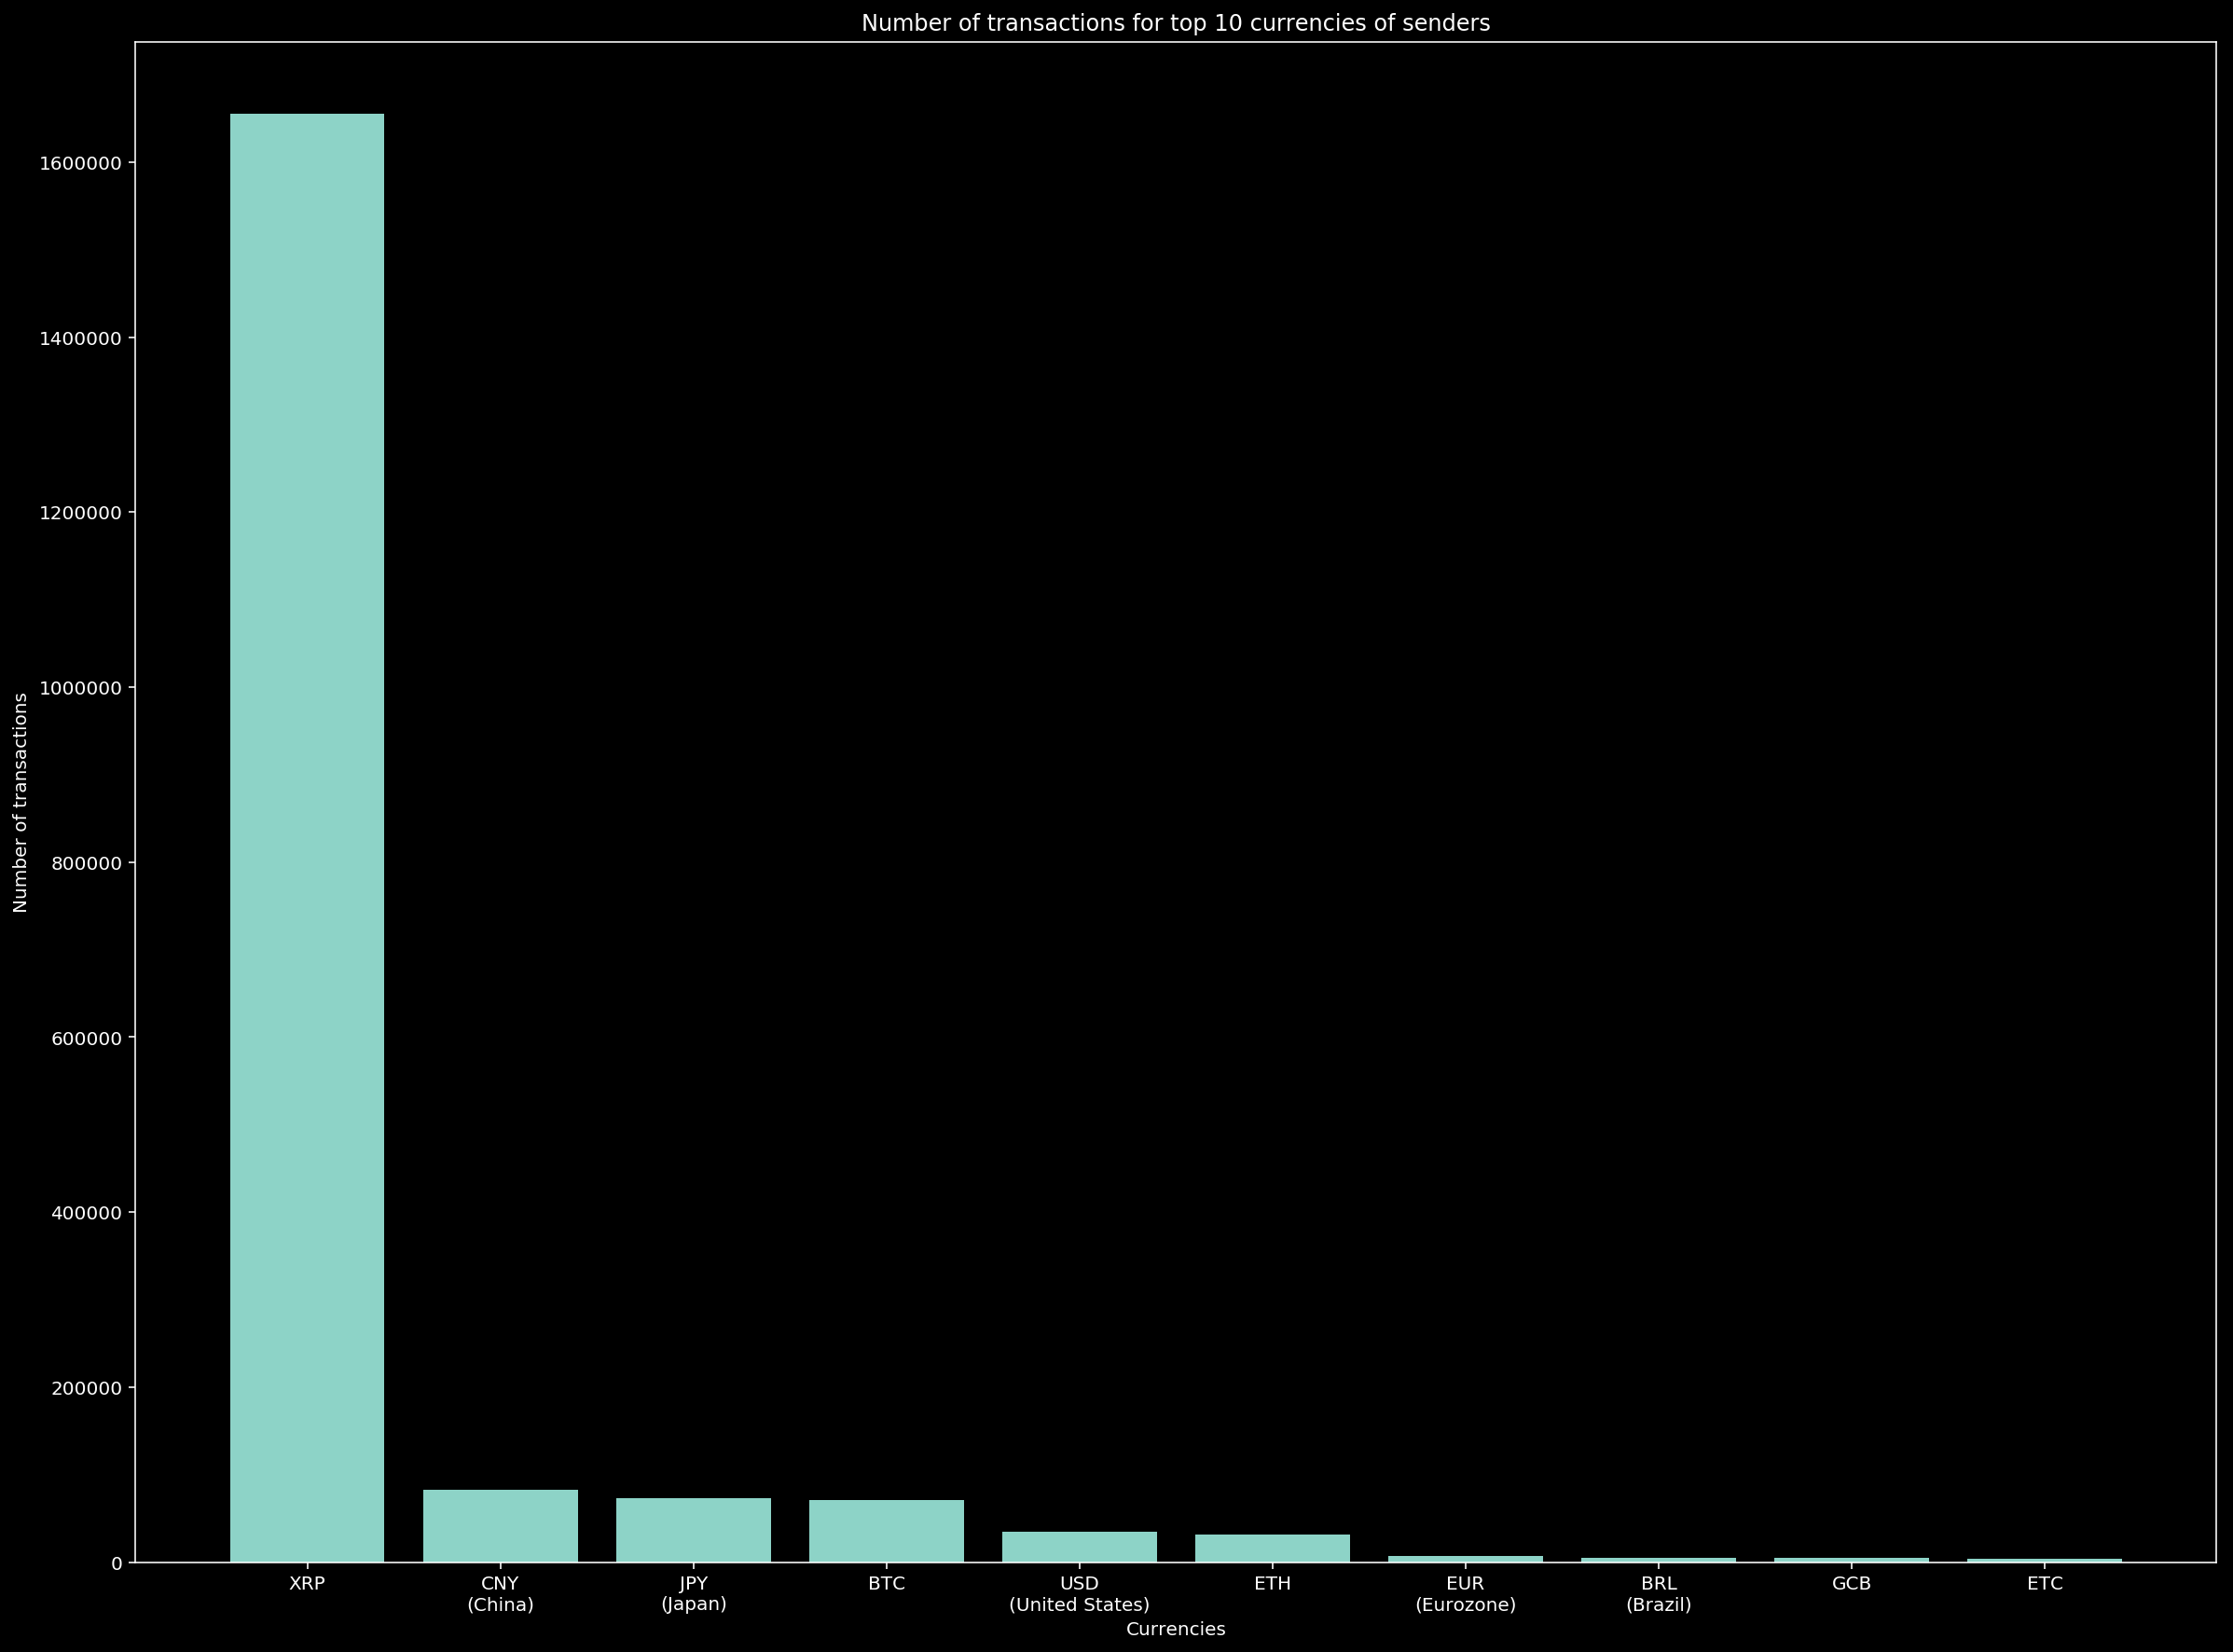

In [39]:
plot_volume(sorted_sender_currency_volume,'sender',nb_of_currencies)

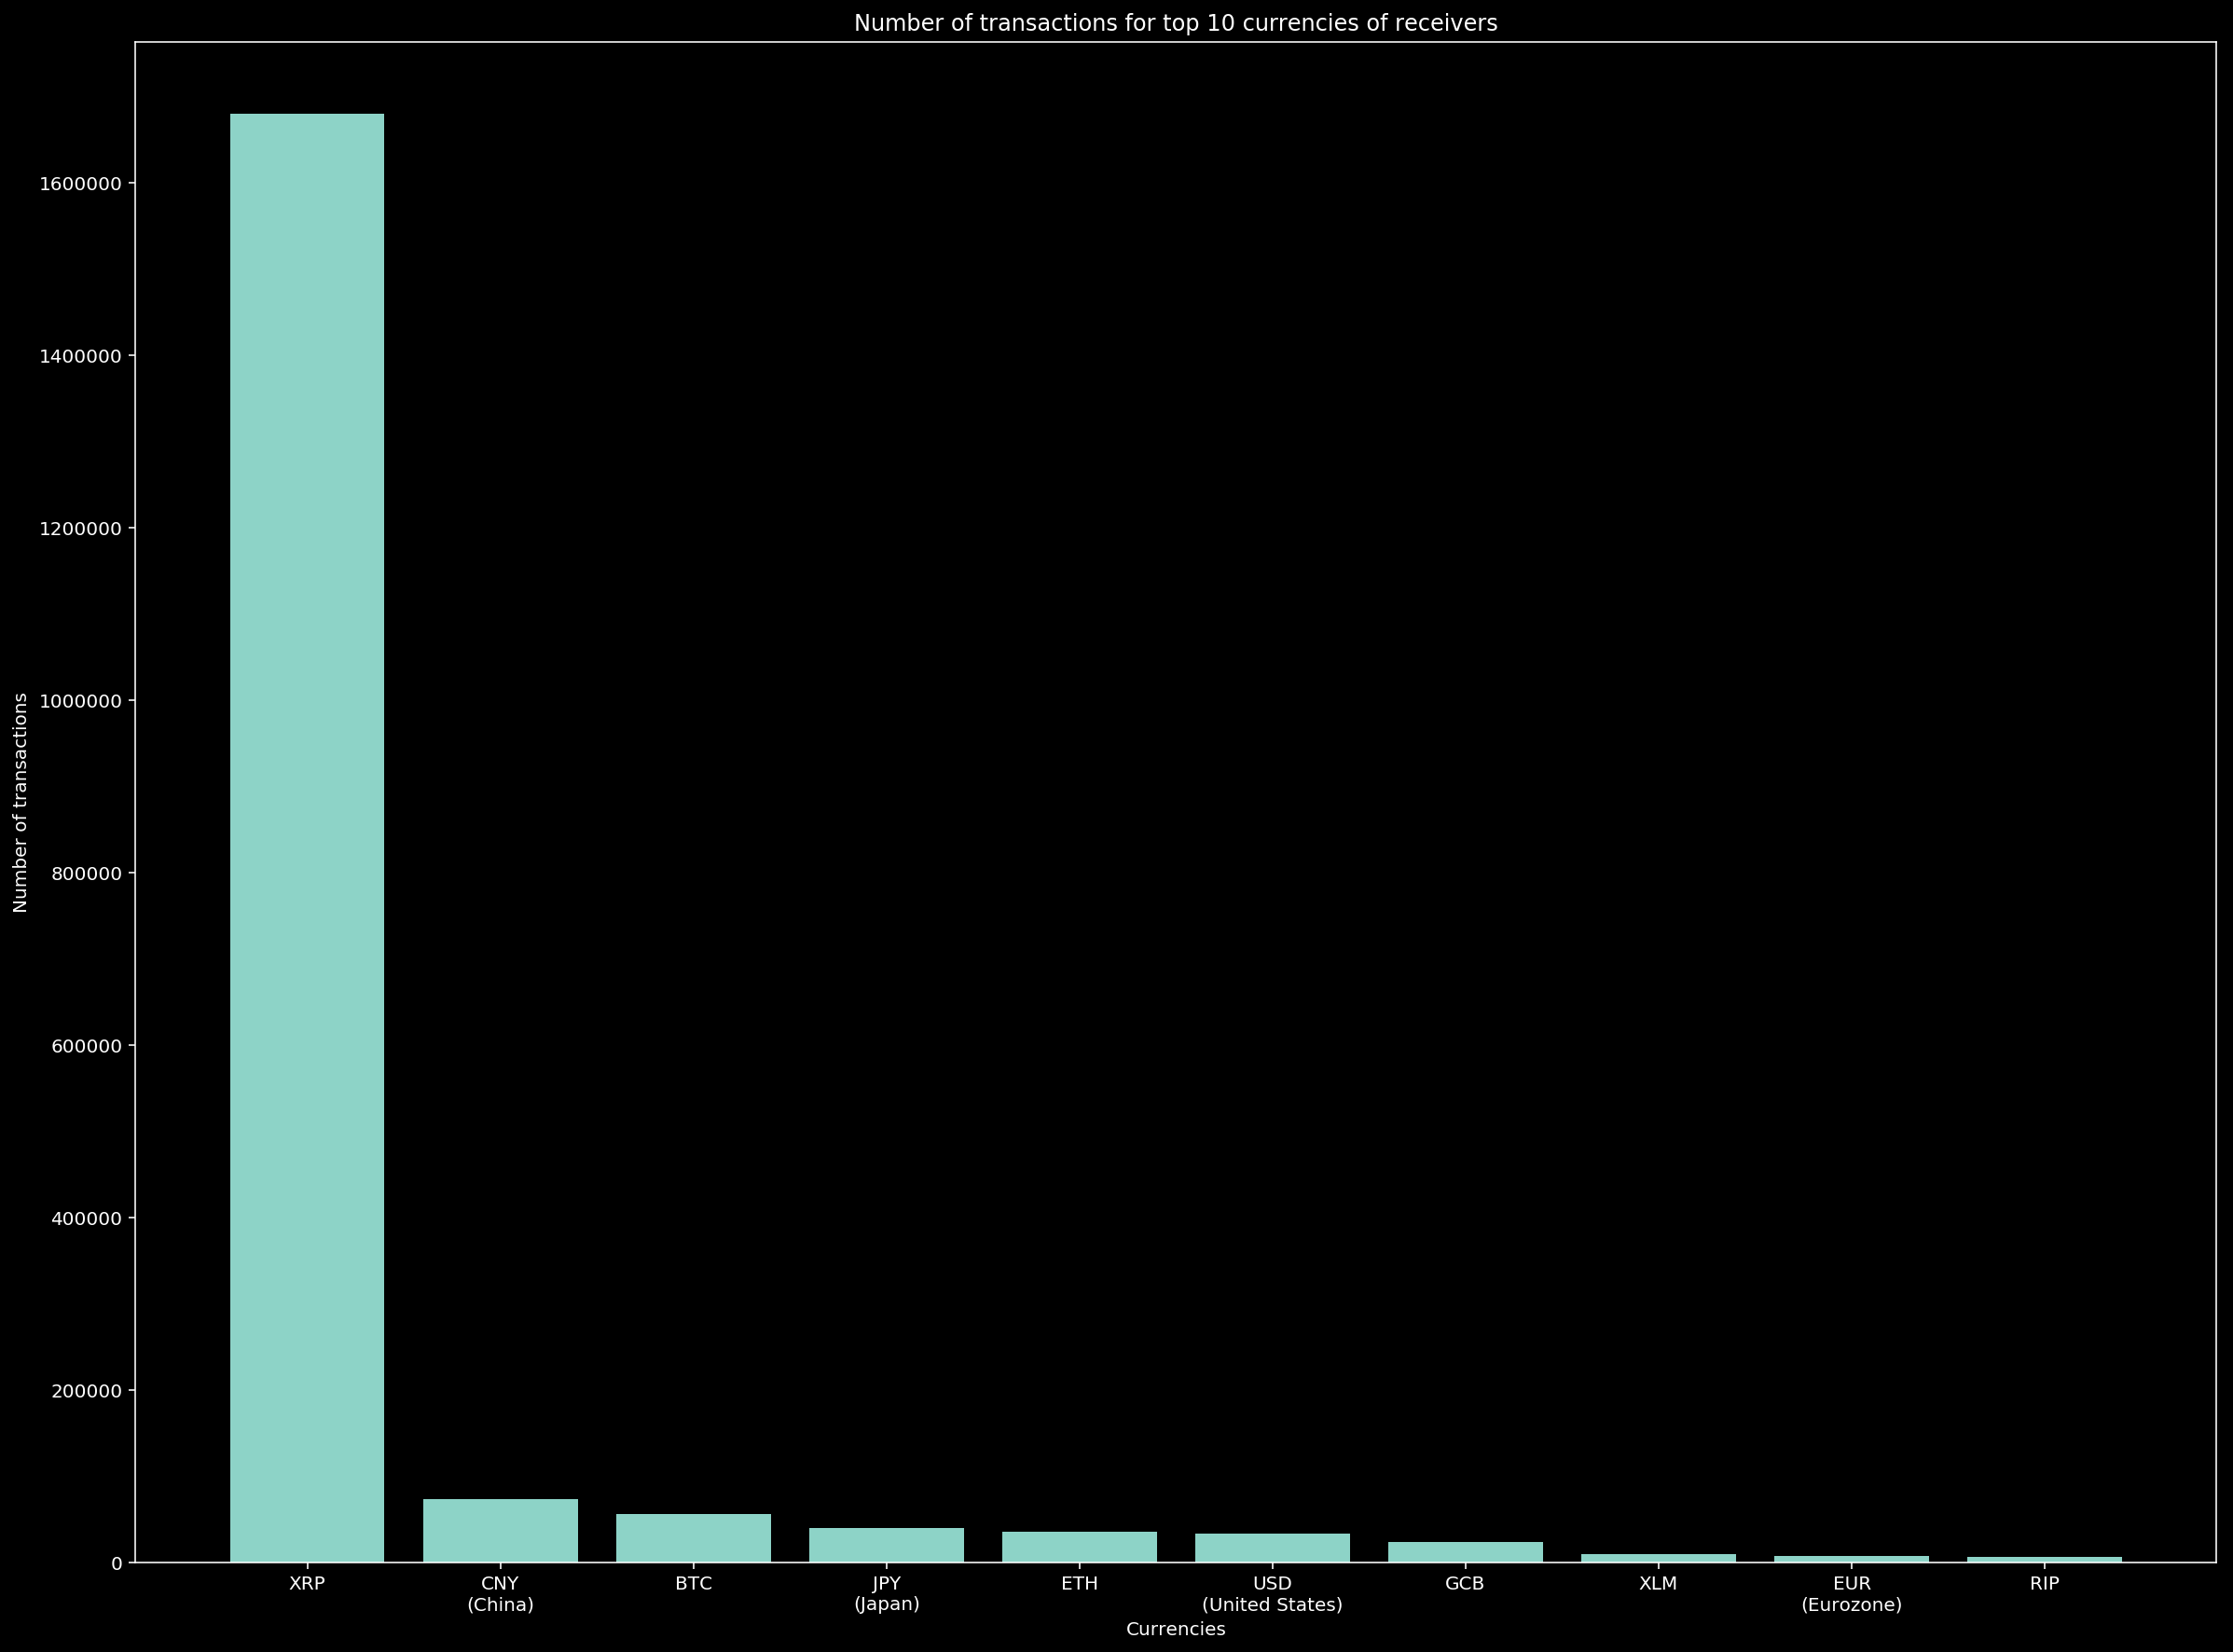

In [40]:
plot_volume(sorted_receiver_currency_volume,'receiver',10)

## 1.5 Sender and receiver currency pairs

In [140]:
nb_of_top_currencies = 15

In [210]:
currencies = dict()
index = 0
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        if txn['senderCurrency'] not in currencies.keys() and txn['senderCurrency'] in list(sorted_sender_currency_volume.keys())[0:nb_of_top_currencies]:
            currencies[txn['senderCurrency']] = index
            index+=1
        if txn['receiverCurrency'] not in currencies.keys() and txn['receiverCurrency'] in list(sorted_receiver_currency_volume.keys())[0:nb_of_top_currencies]:
            currencies[txn['receiverCurrency']] = index
            index+=1

For top used currencies in senders, what are most popular receiver currencies

In [211]:
sender_currency_to_receiver_currency = collections.defaultdict(dict) # dict {sender_curr :{receiver_curr,count}}
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        sender_curr = txn['senderCurrency']
        receiver_curr = txn['receiverCurrency']
        
        sender_currency_to_receiver_currency[sender_curr] = sender_currency_to_receiver_currency.get(sender_curr,{})
        sender_currency_to_receiver_currency[sender_curr][receiver_curr] = sender_currency_to_receiver_currency[sender_curr].get(receiver_curr,0) + 1
        
#for sender_curr, receivers_to_volume in tqdm(sender_currency_to_receiver_currency.items()):
    #sender_currency_to_receiver_currency[sender_curr] = collections.OrderedDict(sorted(receivers_to_volume.items(), key=operator.itemgetter(1),reverse = True)) #order decreasing

In [212]:
sender_matrix = np.zeros((len(currencies.keys()),len(currencies.keys())))

In [213]:
for sender_currency,repartition in tqdm(sender_currency_to_receiver_currency.items()):
    if sender_currency in list(sorted_sender_currency_volume.keys())[0:nb_of_top_currencies]:
        for receiver_currency,count in repartition.items():
            if receiver_currency in list(sorted_receiver_currency_volume.keys())[0:nb_of_top_currencies]:
                sender_matrix[currencies[sender_currency],currencies[receiver_currency]] = count

In [274]:
my_list = []
for currency in currencies.keys():
    try:
        my_list.append('\n()'+ccy.country(ccy.currency(currency).default_country)+')')
    except :
        my_list.append('')

In [279]:
labels = [a+b for a,b in zip(currencies.keys(),my_list)]

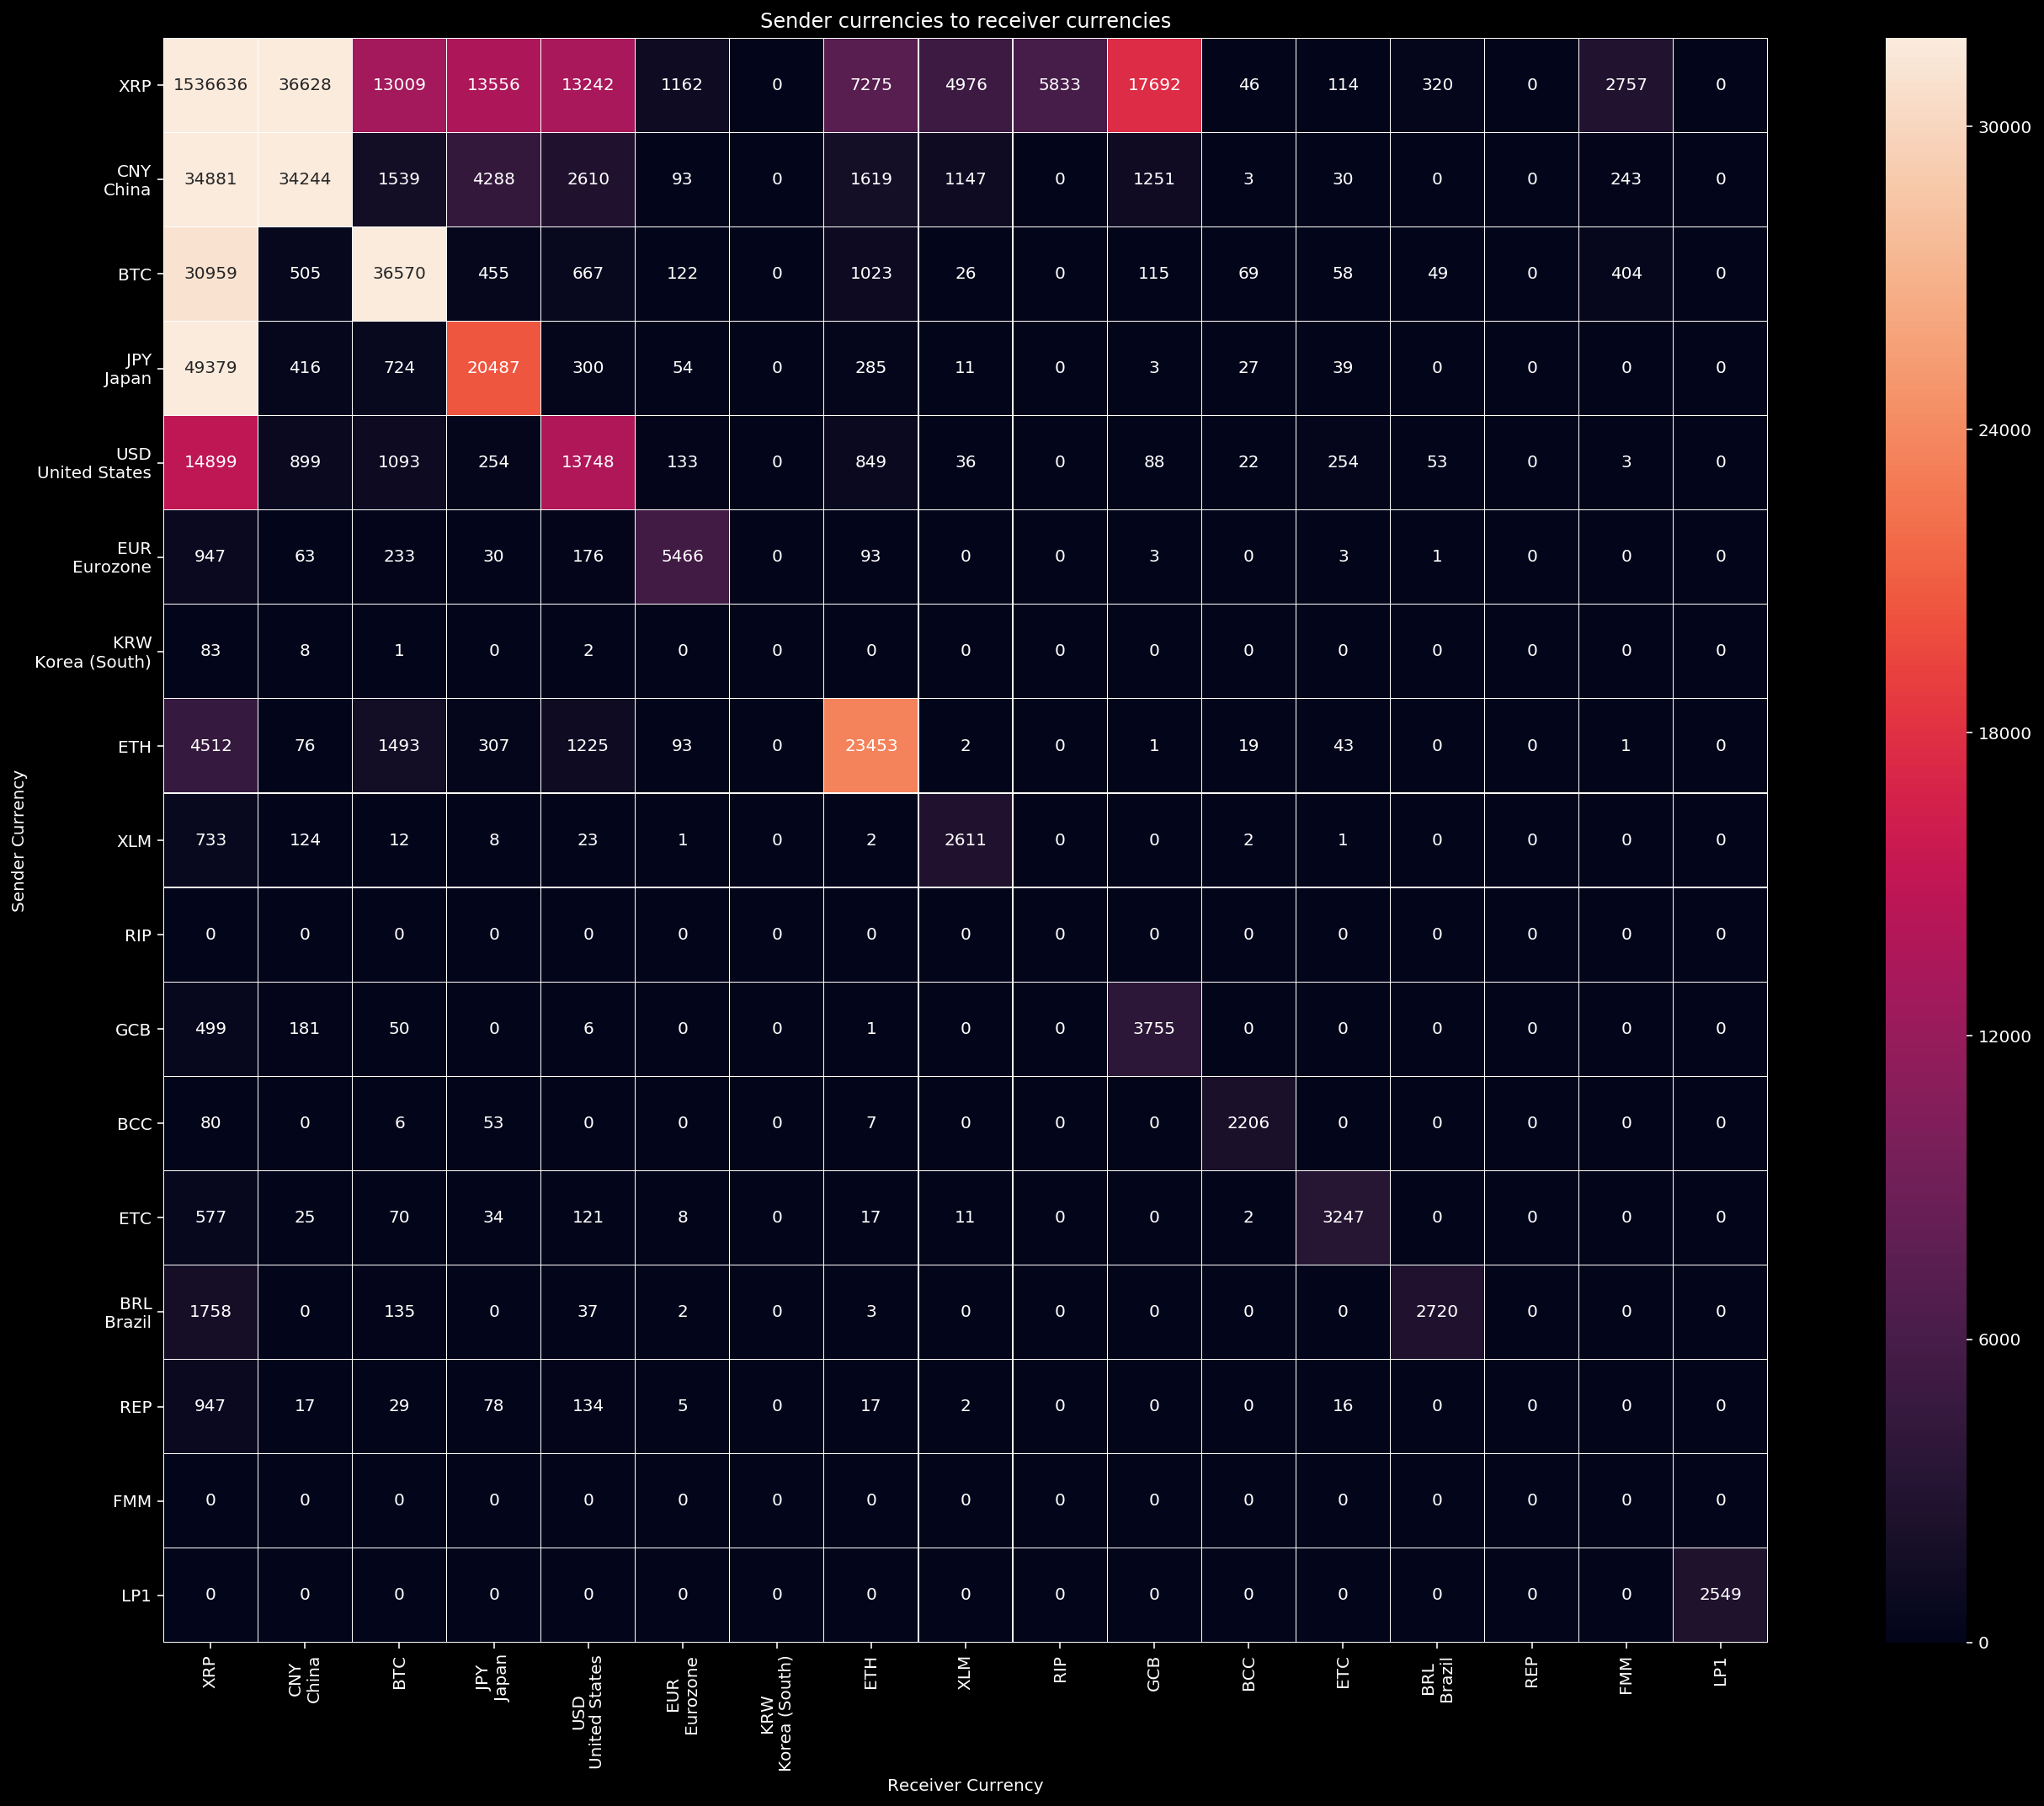

In [280]:
#plt.style.use('dark_background')
plt.figure(figsize=(20,15))
ax = sns.heatmap(sender_matrix, robust = True, annot=True, fmt = "^1.0f", linewidths= 0.1, linecolor = 'white', square = True,
                 xticklabels = labels, yticklabels = labels)
ax.set_title('Sender currencies to receiver currencies')
ax.set_xlabel('Receiver Currency')
ax.set_ylabel('Sender Currency')
plt.tight_layout()
plt.savefig('../visualisations/Sender_to_receiver_heatmap.png')
plt.show()

# USELESS

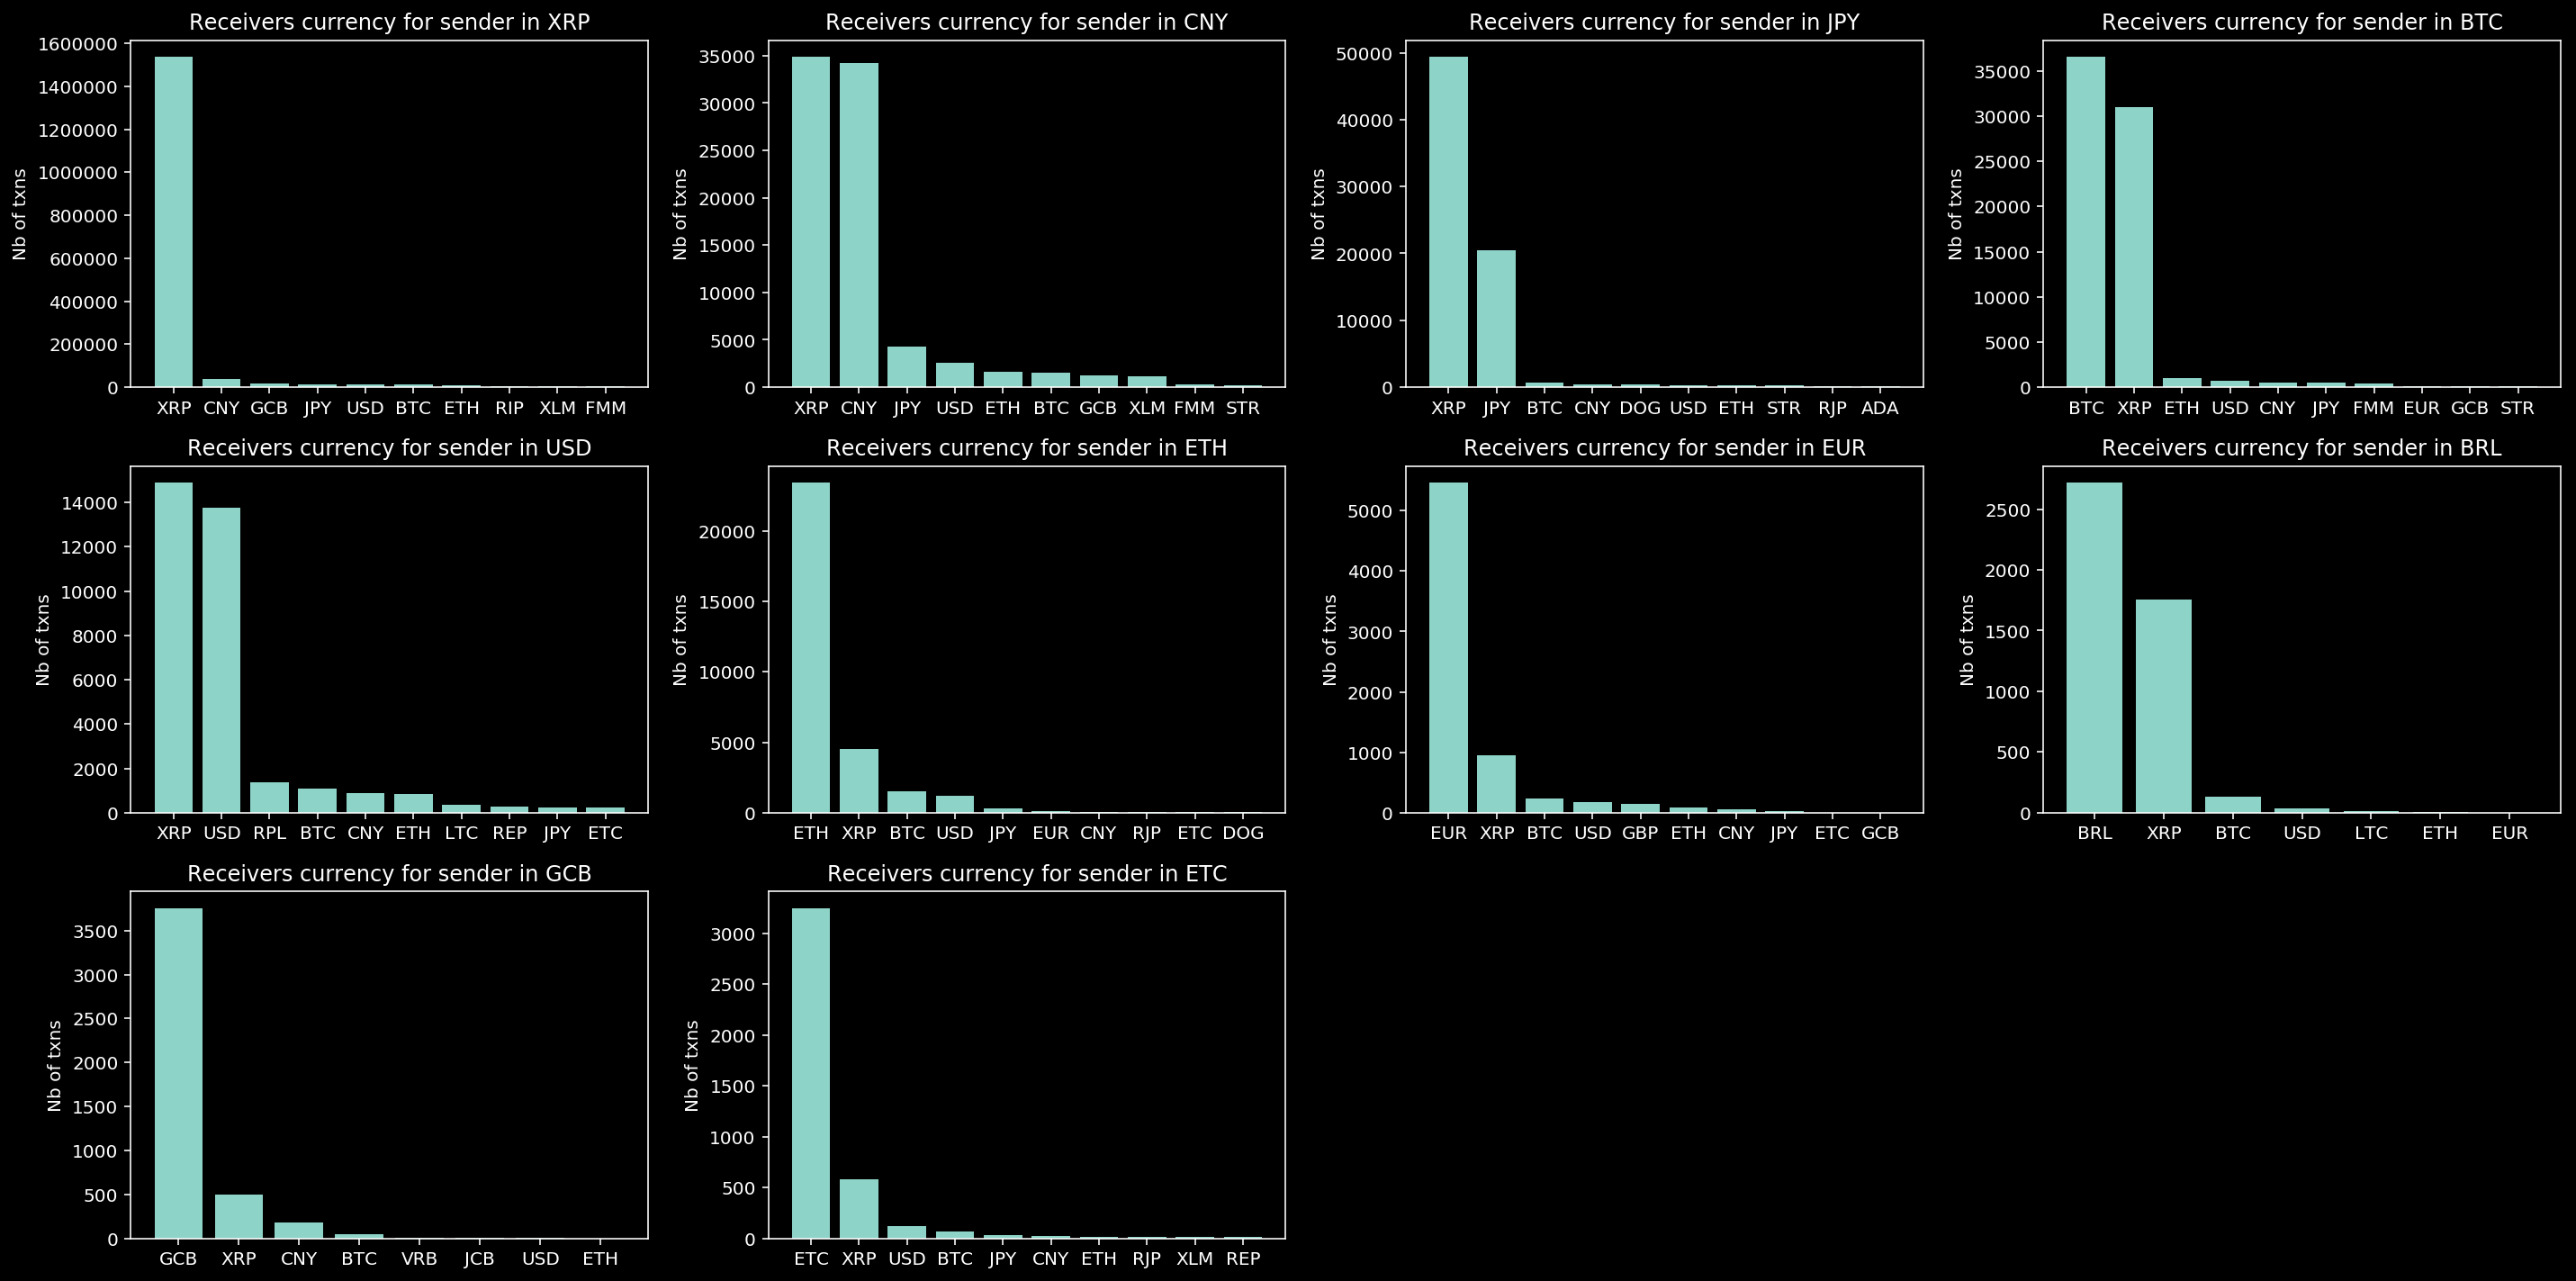

In [547]:
index = 0
for sender_currency in list(sorted_sender_currency_volume.keys())[0:nb_of_top_currencies]: #top 10 currencies of sender
    receivers_to_volume = sender_currency_to_receiver_currency[sender_currency] #get receivers_currency count (dict {currency : count})
    index+=1
    currency = list(receivers_to_volume.keys())[0:nb_of_top_currencies]
    x_pos = np.arange(len(currency))
    count = list(receivers_to_volume.values())[0:nb_of_top_currencies]
    
    plt.subplot(3,4,index)
    #plt.style.use('dark_background')    

    plt.bar(x_pos, count) #bar plot
    plt.xticks(x_pos, currency)
    plt.ylabel('Nb of txns')
    plt.title('Receivers currency for sender in ' + sender_currency)
    
plt.tight_layout()
plt.show()

### 1.5.2 Receiver side
For top used currencies in receivers, what are most popular sender currencies

In [133]:
receiver_currency_to_sender_currency = collections.defaultdict(dict) # dict {receiver_curr :{sender_curr,count}}
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        sender_curr = txn['senderCurrency']
        receiver_curr = txn['receiverCurrency']
        
        receiver_currency_to_sender_currency[receiver_curr] = receiver_currency_to_sender_currency.get(receiver_curr,{})
        receiver_currency_to_sender_currency[receiver_curr][sender_curr] = receiver_currency_to_sender_currency[receiver_curr].get(sender_curr,0) + 1 
        
#for receiver_curr, senders_to_volume in tqdm(receiver_currency_to_sender_currency.items()):
    #receiver_currency_to_sender_currency[receiver_curr] = collections.OrderedDict(sorted(senders_to_volume.items(), key=operator.itemgetter(1),reverse = True)) #decreasing order

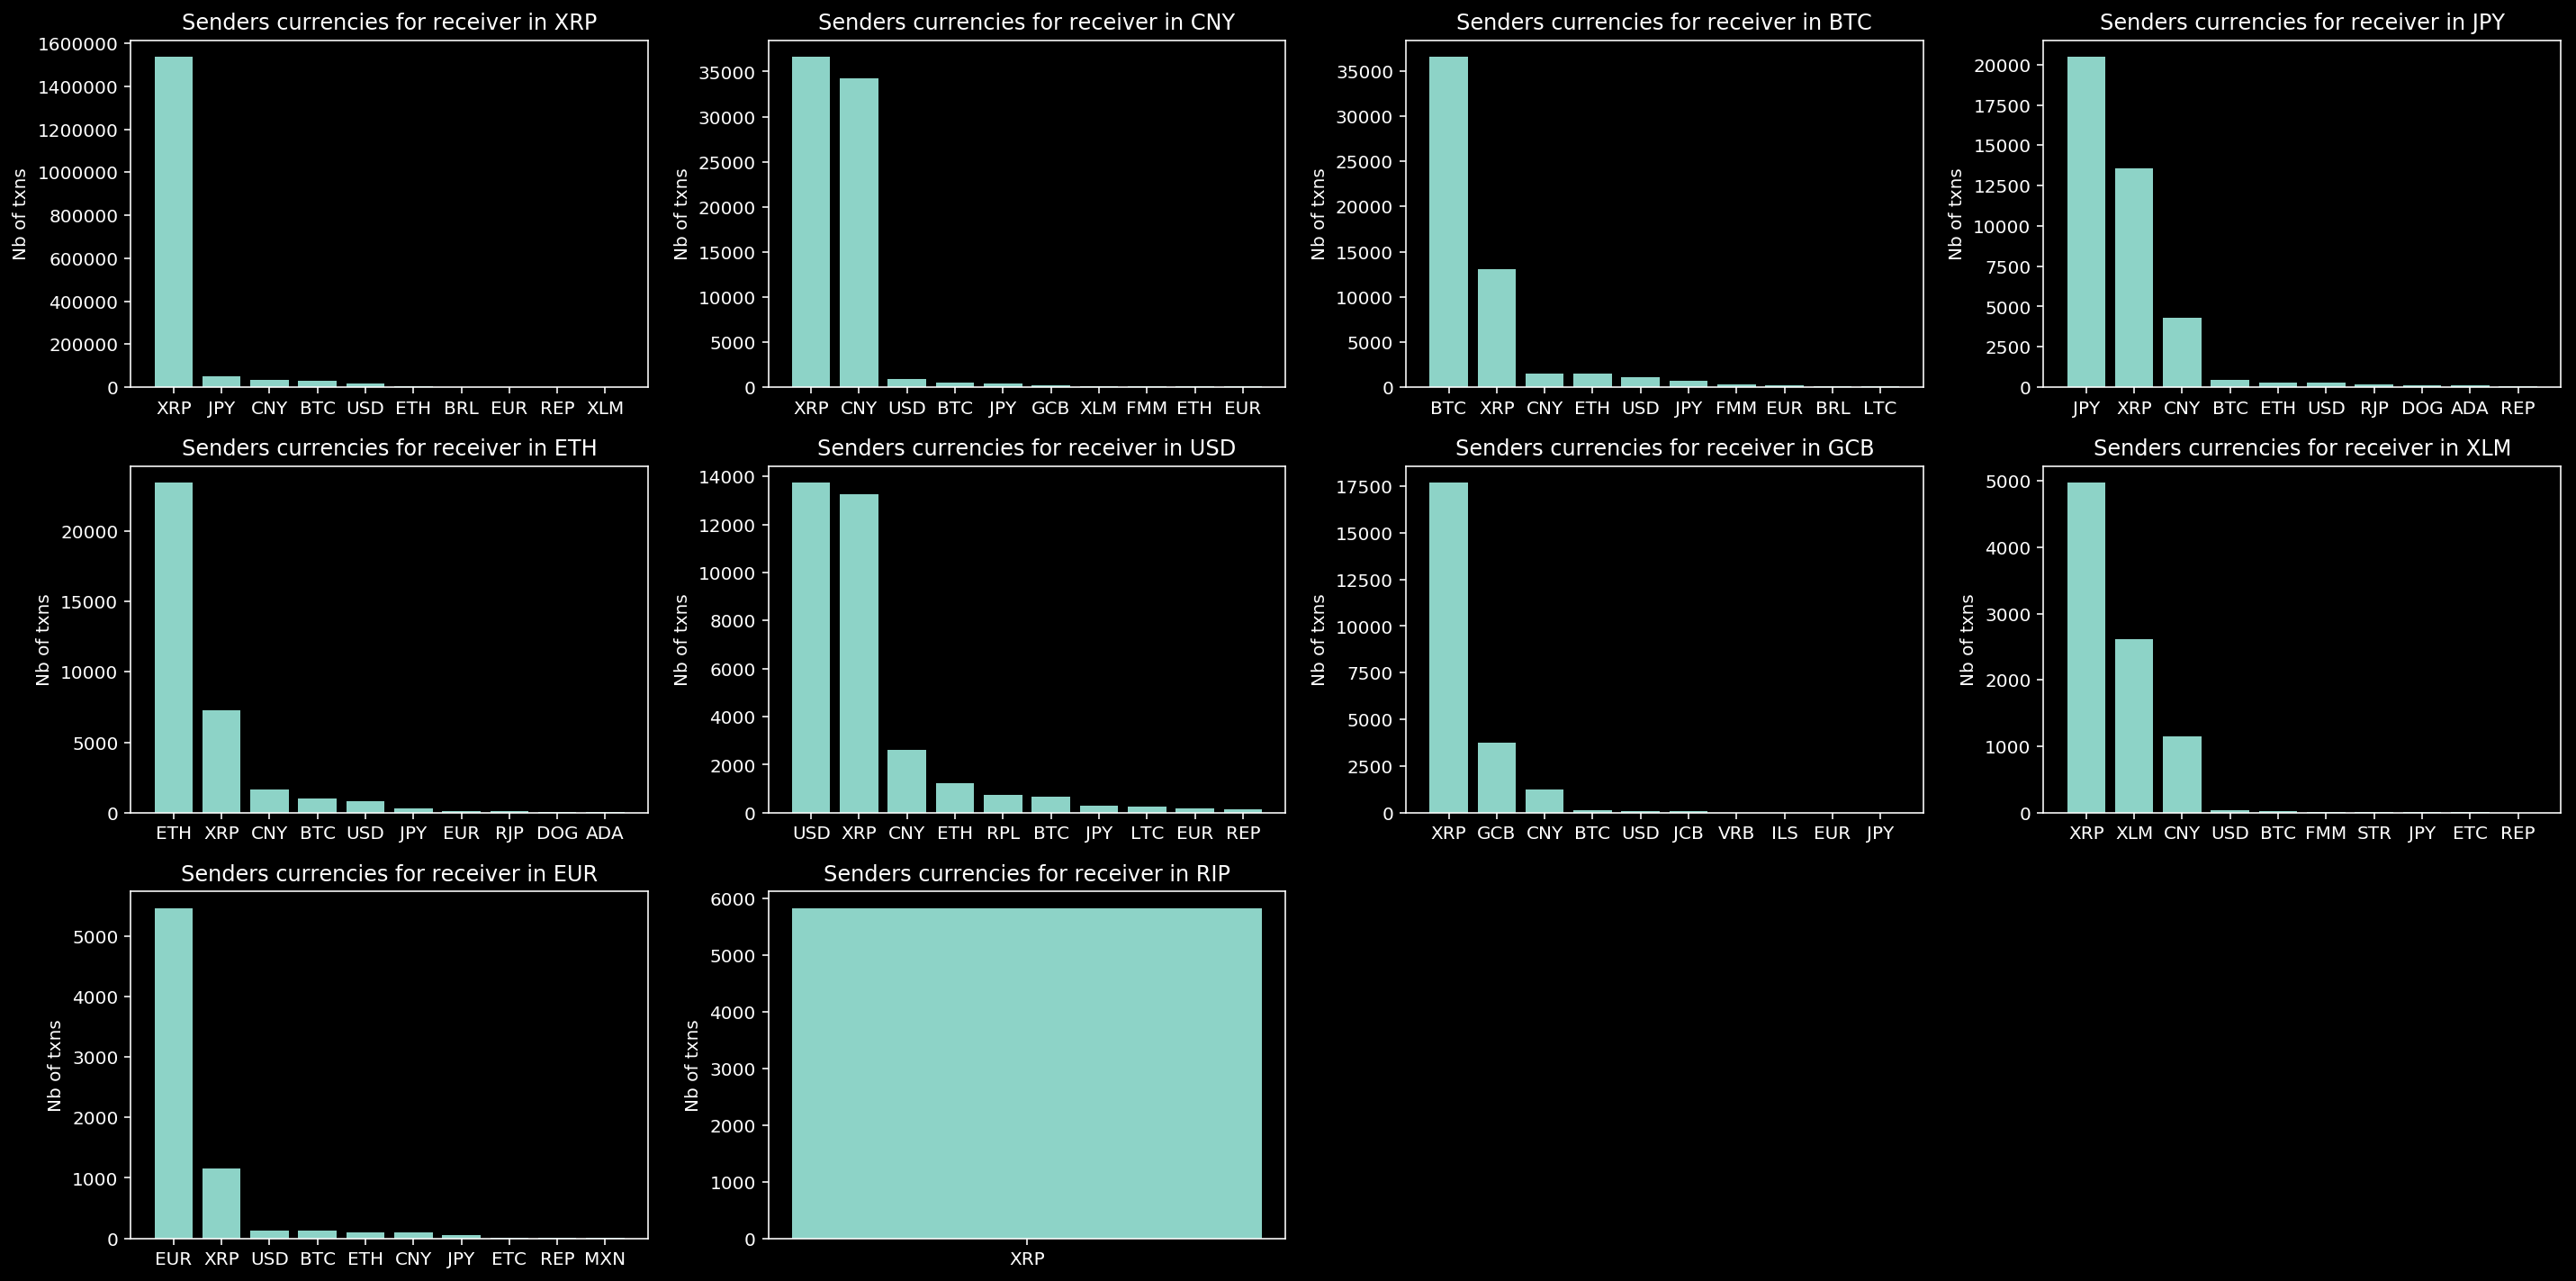

In [552]:
index = 0
for receiver_currency in list(sorted_receiver_currency_volume.keys())[0:nb_of_top_currencies]: #top 10 currencies of receiver
    senders_to_volume = receiver_currency_to_sender_currency[receiver_currency] #get senders_currency count (dict {currency : count})
    index+=1
    objects = list(senders_to_volume.keys())[0:nb_of_top_currencies]
    y_pos = np.arange(len(objects))
    performance = list(senders_to_volume.values())[0:nb_of_top_currencies]
    
    plt.subplot(3,4,index)
    #plt.style.use('dark_background')    
    
    plt.bar(y_pos, performance) #bar plot
    plt.xticks(y_pos, objects)
    plt.ylabel('Nb of txns')
    plt.title('Senders currencies for receiver in '+ receiver_currency)
    
plt.tight_layout()
plt.show()

# 2. Accounts

## 2.1 Account creation (Too long using API)

In [17]:
query_params = dict(start="2012-01-01",end="2019-12-31",interval="week",family="metric",metrics="accounts_created",limit=1000)
created_accounts_per_week = api.get_stats(**query_params)

In [18]:
nb_accounts = 0
for week in tqdm(created_accounts_per_week["stats"]):
    nb_accounts += week["accounts_created"]

In [19]:
print("There are",nb_accounts,"accounts")

There are 1446292 accounts


In [ ]:
all_senders = set()
for txn in tqdm(data):
    all_senders.add(txn["sender"])

In [23]:
all_txn.update(set(df.hash.tolist()))

In [24]:
all_txn = list(all_txn_hashes)

In [28]:
nb_txn = len(all_txn)
nb_txn

27406875

Too long

In [ ]:
creation_txns = []
pbar = tqdm(total = nb_txn-1)
i=0
while(i < nb_txn):
    hsh = all_txn[i]
    transaction = api.get_transaction(hsh)
    if(list(transaction.keys()) == ['status', 'error']):
        time.sleep(int(transaction["error"].headers.get('Retry-After')) + 1)
    else:
        i+=1
        pbar.update(1)
        for affectedNode in transaction["transaction"]["meta"]["AffectedNodes"]:
            if "CreatedNode" in affectedNode.keys():
                if(affectedNode["CreatedNode"]["LedgerEntryType"] == "AccountRoot"):
                    creation_txns.append(hsh)
pbar.close()                    

In [15]:
creation_txns

['411790751304693B1ABA32443A762713CA49B67D9F995A4DA4E8FD296EDC7E40',
 '59E57301AD19F764468F3D6DA874071DDF1B40416CAD88D9F6B79673F2CAC608',
 '58A8919EBDD59FD4BEB8194D36FE09062F3247ABA2B9497DCEB56575EF3E3311',
 'EEEB8A00C0EA1687E95B94BDB39A98F827BE20EB6426CC6960DABA06CEFF1BF3',
 '40A65FEF00CB908A86D2EF2A858A7684E4BBB78739E9296E9551F68638A89E2B',
 'C112F9C5AB5FE01F7753C38EFADE2909228B27AB642DF286CA42DC6518DD2FB7',
 '2302E4FCB121561AA2DEDEE0116AD451A982993A0DB6731FDD1DA78B511DDB51',
 'EC283B2A36D56685539F1DA284EE1E9125580299968B0C7FFD73E6FCBD16F7EF',
 'E1373B461997CFFE390FC45B3F75BA99C6966A37098638A6278F9EE5EEFB3891',
 '4AA7EFDABA33F1552FF4C536EAE65CBA605D7FA61CE765F9D9E79C8444FAF3B3',
 'FABD792DB5B44B70087FE5D1DA2E6D82B802F847871BD3D73F0AA43B6B0BB9BF',
 '08D4A53414F1B6629BCFB60498D1982DC027CE5267B47411B01DD7ADC77ECA17',
 '9819BF1E715263A59D781C1BCB5FB6036917955394017E3C97BE19336B8F753E',
 'E6D2C569927E0F5853FA138BF760B9F43A46B0F6ABB44B9684C40380DF67ADFD',
 'DF14E2B855218E0181AAB1E949F8C913

## 2.2 How many times account make transactions

We want to know it senders appears several times in transactions

In [32]:
all_senders = df.sender.tolist() #all_senders is a list (with duplicates)

In [33]:
for txn in tqdm(data):
    all_senders.append(txn["sender"])

In [34]:
nb_txn_by_sender = Counter(all_senders).most_common() #count nb of occurences of each sender and sort them reverse

In [35]:
set_senders = set(all_senders) #senders with no duplicates

In [37]:
senders_with_at_least_2_txn = [ sender for sender, occurence in tqdm(list(nb_txn_by_sender)) if occurence > 1 ]

In [38]:
print("There are", len(senders_with_at_least_2_txn)/len(set_senders)*100, "% of senders than appears at least two times")

There are 59.685003878942325 % of senders than appears at least two times


# 3. Trust lines

## 3.0 Getting trust lines

In part 3.0.1 we get all trust lines we need and we save it to disk so we don't have to run it again because it is quite long.<br>
In part 3.0.2 we load the trust lines from the disk

### 3.0.1 Get trust lines

In [10]:
all_wallets = set(df.sender.tolist())|set(df.sender.tolist())

In [11]:
all_wallets
for txn in tqdm(data):
    all_wallets.add(txn["sender"])
    all_wallets.add(txn["receiver"])

In [13]:
all_wallets = list(all_wallets)

In [14]:
def get_lines(id):
    answer = rpc.account_lines(all_wallets[id])
    if(answer["status"] == 'success'):
        return answer
    else:
        print("error")
        return

In [15]:
def get_lines_range(id_range, store=None):
    """process a number of ids, storing the results in a dict"""
    if store is None:
        store = []
    for id in tqdm(id_range):
        store.append(get_lines(id))
    return store

In [16]:
from threading import Thread

def threaded_process(nthreads, id_range):
    """process the id range in a specified number of threads"""
    store = []
    threads = []
    # create the threads
    for i in range(nthreads):
        ids = id_range[i::nthreads]
        t = Thread(target=get_lines_range, args=(ids,store))
        threads.append(t)

    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return store

In [ ]:
lines = threaded_process(4, range(len(all_wallets)))

In [18]:
while None in lines:
    lines.remove(None) #if there was an error getting the trust line

In [ ]:
with open('../data/trust_lines/trust_lines.pickle', 'wb') as f:
    pickle.dump(lines, f) #save to disk

### 3.0.2 Open trust lines file

In [14]:
with open('../data/trust_lines/trust_lines.pickle', 'rb') as f:
    trust_lines = pickle.load(f) #load from disk

Here is a example of what data looks like for one wallet

In [43]:
print(json.dumps(trust_lines[0],indent = 4))

{
    "account": "rUPiAddSwJTrkWzGX4aHG1u7eZg9GTV6Bd",
    "ledger_current_index": 46580945,
    "lines": [
        {
            "account": "rfYv1TXnwgDDK4WQNbFALykYuEBnrR4pDX",
            "balance": "0.00001492689992518072",
            "currency": "BTC",
            "limit": "0",
            "limit_peer": "0",
            "no_ripple": true,
            "quality_in": 0,
            "quality_out": 0
        },
        {
            "account": "rfYv1TXnwgDDK4WQNbFALykYuEBnrR4pDX",
            "balance": "0",
            "currency": "LTC",
            "limit": "0",
            "limit_peer": "0",
            "no_ripple": true,
            "quality_in": 0,
            "quality_out": 0
        },
        {
            "account": "rvYAfWj5gh67oV6fW32ZzP3Aw4Eubs59B",
            "balance": "0",
            "currency": "USD",
            "limit": "0",
            "limit_peer": "0",
            "no_ripple": true,
            "quality_in": 0,
            "quality_out": 0
        },
        {
 

## 3.1 Trust lines with gateways

First we get the informations about the gateways with the ripple data API:

In [43]:
gateways = api.get_all_gateways()

In [44]:
gateways_address = set() #all gateway addresses
address_to_gateway = {} #dict form address to gateway name
for currency,gateways in tqdm(gateways.items()):
    for gateway in gateways:
        gateways_address.add(gateway["account"]) 
        address_to_gateway[gateway['account']] = gateway['name']

We want :
* Know what are the most popular wallet in trust lines
* Map wallet to countries given their trust lines currency 

In [45]:
ctr_lines_with_gateways = 0 #counter for the number of trust lines with gateways
ctr_lines = 0 #counter for the number of trust lines
account_to_currency = collections.defaultdict(list) #dict from account to countries (based on currency of its trust lines)
wallet_count_in_trust_lines = {} #count in how many trust lines a wallet appear
for info in tqdm(trust_lines): 
    for line in info["lines"]:
        ctr_lines += 1
        wallet_count_in_trust_lines[line["account"]] = wallet_count_in_trust_lines.get(line["account"], 0) + 1
        if line["account"] in gateways_address:
            ctr_lines_with_gateways += 1
            
            #if currency is not crypto add it to the list for the account
            try: 
                currency = ccy.currency(line["currency"]).code
                if currency not in account_to_currency[info["account"]]:
                    account_to_currency[info["account"]].append(currency)
            except:
                continue

Now that we have collected the data we wanted, let's analyse it :
 * 3.1.1 What percentage of trust lines are with gateways
 * 3.1.2 Most Common wallets in trust lines 
 * 3.1.3 Over the accounts with trust lines, how many have one with a gateway
 * 3.1.4 Over all accounts, how many have a trust line with a gateway
 * 3.1.5 Currency of trust lines with gateways

### 3.1.1 What percentage of trust lines are with gateways

In [16]:
print("There are", ctr_lines_with_gateways/ctr_lines*100,"% of thurst lines that are with gateways")

There are 69.24400759363412 % of thurst lines that are with gateways


### 3.1.2 Most Common wallets in trust lines 

In [17]:
wallet_occurences = [(k,v) for k,v in list(wallet_count_in_trust_lines.items())] # convert dict to list of pairs

In [18]:
wallet_occurences.sort(reverse = True,key=lambda wallet_occurences: wallet_occurences[1]) # sort by decressing occurence

In [19]:
gateway_occurences = [(k,v) for k,v in wallet_occurences if k in gateways_address]  # get occurences in trust lines for gateways

In [20]:
gateway_top = [i for i,j in zip(wallet_occurences,gateway_occurences) if i == j] # get first matching elements in occurence of wallets and gateways

In [21]:
print("The",len(gateway_top),"most common wallet in trust lines are gateways")

The 7 most common wallet in trust lines are gateways


### 3.1.3 Over the accounts with trust lines, how many have one with a gateway

In [22]:
nb_account_with_turst_lines = len([x for x in trust_lines if len(x["lines"]) >= 1]) #nb of accounts with at least one trust line

In [23]:
nb_account_with_trust_lines_with_gateways =len(account_to_currency.keys()) #nb of accounts with trust line with gateways

In [24]:
print("Over the accounts that have a trust line",nb_account_with_trust_lines_with_gateways/nb_account_with_turst_lines* 100,"% of them have one with a gateway.")

Over the accounts that have a trust line 69.59407239337753 % of them have one with a gateway.


### 3.1.4 Over all accounts, how many have a trust line with a gateway

In [25]:
print("Over all accounts",nb_account_with_trust_lines_with_gateways/len(trust_lines)*100,"% of them have a trust line with a gateway.")

Over all accounts 30.165252427154627 % of them have a trust line with a gateway.


### 3.1.5 Currency of trust lines with gateways

In [26]:
count_len = {}
for country_list in tqdm(account_to_currency.values()):
    # how many wallets are associated with "n" countries
    count_len[len(country_list)] = count_len.get(len(country_list),0) + 1 
for k,v in count_len.items():
    #percentage of total number of wallets that has trust lines with gateways
    count_len[k] = v/nb_account_with_trust_lines_with_gateways*100 

In [27]:
print("Over the wallets that have trust lines with gateways",count_len[1],"% of them have trust lines with gateways in just 1 currency")
print("And",count_len[2],"% of them have trust lines with gateways in 2 currencies")

Over the wallets that have trust lines with gateways 75.94343467275246 % of them have trust lines with gateways in just 1 currency
And 19.944575760045645 % of them have trust lines with gateways in 2 currencies


## 3.2 Usage of trust line currencies

We want to analyse how wallets use the currency of their trust lines. The idea is to see if a wallet could be mapped to a country knowing it's trust lines since most of since have trust lines with gateways in 1 or 2 currencies

In [47]:
account_to_currency = collections.defaultdict(set) #dict from account to currency
account_with_trust_lines = set() 
account_with_no_trust_lines = set()
for trust_line in tqdm(trust_lines):
    account = trust_line['account']
    
    #The wallet don't have any trust lines
    if not trust_line['lines']: 
        account_with_no_trust_lines.add(account)
        
    #The wallet has trust lines
    else:
        account_with_trust_lines.add(account)
        for line in trust_line['lines']:
            line_currency = line['currency']
            account_to_currency[account].add(line_currency)

In [48]:
print('We have that',len(account_with_trust_lines)/(len(account_with_trust_lines)+len(account_with_no_trust_lines))*100,'% of wallets that have a trust line')

We have that 43.34457144086471 % of wallets that have a trust line


Now we iterate trough all transactions and count how many times each wallets (as sender and receiver) use the currency of the transaction. We have a counter for currencies of its trust lines, one for XRP and one for other currencies.

In [30]:
sender_to_volume = collections.defaultdict(dict) #dcit from sender (wallet) to usage of currency 
receiver_to_volume = collections.defaultdict(dict)

for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        
        #Senders
        sender = txn['sender']
        if sender in account_to_currency.keys(): # if sender has trust lines
            currency_list = account_to_currency[sender]
            sender_currency = txn['senderCurrency']
            
            # Currency of trust lines
            if sender_currency in currency_list:
                sender_to_volume[sender] = sender_to_volume.get(sender,{})
                sender_to_volume[sender][sender_currency] = sender_to_volume[sender].get(sender_currency,0) + 1
                
            # XRP
            elif sender_currency == 'XRP':
                sender_to_volume[sender] = sender_to_volume.get(sender,{})
                sender_to_volume[sender]['XRP'] = sender_to_volume[sender].get('XRP',0) + 1
                
            # Others
            else:
                sender_to_volume[sender] = sender_to_volume.get(sender,{})
                sender_to_volume[sender]['others'] = sender_to_volume[sender].get('others',0) + 1
                
        #Receivers
        receiver = txn['receiver']
        if receiver in account_to_currency.keys(): # if receiver has trust lines
            currency_list = account_to_currency[receiver]
            receiver_currency = txn['receiverCurrency']
            
            # Currency of trust lines
            if receiver_currency in currency_list:
                receiver_to_volume[receiver] = receiver_to_volume.get(receiver,{})
                receiver_to_volume[receiver][receiver_currency] = receiver_to_volume[receiver].get(receiver_currency,0) + 1
                
            # XRP
            elif receiver_currency == 'XRP':
                receiver_to_volume[receiver] = receiver_to_volume.get(receiver,{})
                receiver_to_volume[receiver]['XRP'] = receiver_to_volume[receiver].get('XRP',0) + 1
                
            # Others
            else:
                receiver_to_volume[receiver] = receiver_to_volume.get(receiver,{})
                receiver_to_volume[receiver]['others'] = receiver_to_volume[receiver].get('others',0) + 1

We know convert counts to percentages for senders and receivers

In [31]:
for sender, volume_list in tqdm(sender_to_volume.items()):
    nb_txns = sum(volume_list.values()) #sum of all transactions 
    for currency, volume in volume_list.items():
        sender_to_volume[sender][currency] = sender_to_volume[sender][currency]/nb_txns*100 #percentage
        
for receiver, volume_list in tqdm(receiver_to_volume.items()):
    nb_txns = sum(volume_list.values()) #sum of all transactions 
    for currency, volume in volume_list.items():
        receiver_to_volume[receiver][currency] = receiver_to_volume[receiver][currency]/nb_txns*100 #percentage

In [32]:
sender_only_trust = set() #senders using only the currency of their trust lines
sender_trust_and_XRP = set() #senders using the currency of their trust lines and XPR
sender_trust_and_others = set() #senders using the currency of their trust lines and 'others' currency (not XRP)

for sender,volume in tqdm(sender_to_volume.items()):
    #Only trust line currencies
    if 'XRP' not in volume.keys() and 'others' not in volume.keys(): 
        sender_only_trust.add(sender)
        
    #Trust line currencies and XRP
    if 'XRP' in volume.keys() and 'others' not in volume.keys() and len(volume.keys()) > 1:
        sender_trust_and_XRP.add(sender)
        
    #Trust line currencies and 'others' currencies
    if 'XRP' not in volume.keys() and 'others' in volume.keys() and len(volume.keys()) > 1:
        sender_trust_and_others.add(sender)
        
        
receiver_only_trust = set() #receivers using only the currency of their trust lines
receiver_trust_and_XRP = set() #receivers using the currency of their trust lines and XPR
receiver_trust_and_others = set() #receivers using the currency of their trust lines and 'others' currency (not XRP)

for receiver,volume in tqdm(receiver_to_volume.items()):
    #Only trust line currencies
    if 'XRP' not in volume.keys() and 'others' not in volume.keys():
        receiver_only_trust.add(receiver)
        
    #Trust line currencies and XRP
    if 'XRP' in volume.keys() and 'others' not in volume.keys() and len(volume.keys()) > 1:
        receiver_trust_and_XRP.add(receiver)
        
    #Trust line currencies and 'others' currencies    
    if 'XRP' not in volume.keys() and 'others' in volume.keys() and len(volume.keys()) > 1:
        receiver_trust_and_others.add(receiver)

In [34]:
print('We have',len(sender_only_trust)/len(sender_to_volume)*100,'% of senders that have trust line that only use currency of their trust lines')
print('We have',len(sender_trust_and_XRP)/len(sender_to_volume)*100,'% of senders that have trust line that use XRP and currencies of their trust lines')
print('We have',len(sender_trust_and_others)/len(sender_to_volume)*100,'% of senders that have trust line that use currencies of their trust lines and other currencies (others that XRP)')
print('We have',(len(sender_only_trust)+len(sender_trust_and_XRP)+len(sender_trust_and_others))/len(sender_to_volume)*100,'% of senders that have trust line that use them')
print()
print('We have',len(receiver_only_trust)/len(receiver_to_volume)*100,'% of receiver that have trust line that only use currency of their trust lines')
print('We have',len(receiver_trust_and_XRP)/len(receiver_to_volume)*100,'% of receiver that have trust line that use XRP and currencies of their trust lines')
print('We have',len(receiver_trust_and_others)/len(receiver_to_volume)*100,'% of receiver that have trust line that use currencies of their trust lines and other currencies (others that XRP)')
print('We have',(len(receiver_only_trust)+len(receiver_trust_and_XRP)+len(receiver_trust_and_others))/len(receiver_to_volume)*100,'% of receiver that have trust line that use them')

We have 21.030924121535218 % of senders that have trust line that only use currency of their trust lines
We have 20.94267240602993 % of senders that have trust line that use XRP and currencies of their trust lines
We have 0.23773931523872988 % of senders that have trust line that use currencies of their trust lines and other currencies (others that XRP)
We have 42.211335842803884 % of senders that have trust line that use them

We have 4.890562290537465 % of receiver that have trust line that only use currency of their trust lines
We have 22.727460796888575 % of receiver that have trust line that use XRP and currencies of their trust lines
We have 0.0558566759071538 % of receiver that have trust line that use currencies of their trust lines and other currencies (others that XRP)
We have 27.673879763333197 % of receiver that have trust line that use them


Now we put those number in perspective to see what percentage of transactions their represents

In [50]:
sender_use_trust = sender_only_trust | sender_trust_and_XRP | sender_trust_and_others #union of all senders that uses their trust lines
receiver_use_trust = receiver_only_trust | receiver_trust_and_XRP | receiver_trust_and_others  #union of all receivers that uses their trust lines

In [49]:
sender_nb_txn_use = 0 #counter for transactions of senders that use trust lines
receiver_nb_txn_use = 0 #counter for transactions of receivers that use trust lines

for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        #Senders
        if txn['sender'] in sender_use_trust:
            sender_nb_txn_use+=1
            
        #Receivers
        if txn['receiver'] in receiver_use_trust:
            receiver_nb_txn_use+=1
            
print('Senders that uses their trust lines represents',sender_nb_txn_use/len(data)*100,'% of transactions.')
print('Receiver that uses their trust lines represents',receiver_nb_txn_use/len(data)*100,'% of transactions.')


Senders that uses their trust lines represents 13.632137433943777 % of transactions.
Receiver that uses their trust lines represents 11.4749290802566 % of transactions.


# 4 Gateways

## 3.3 Most used gateways per currency

Be sure to run 1.4 before

In [41]:
wallet_to_gateway_trust_lines = collections.defaultdict(list)
for account_line in tqdm(trust_lines):
    for line in account_line['lines']:
        if line['account'] in gateways_address:
            wallet = account_line['account']
            wallet_to_gateway_trust_lines[wallet].append((line['account'],line['currency']))

### 3.3.1 Senders

We want to see if transactions goes mainly through trust lines with gateways

In [20]:
usage_of_trust_lines = collections.defaultdict(dict)

# For a given currency transactions checks 
# if the senders uses one of its trust lines with gateways for this currency in the transaction
#     increment the counter for the this line
# else
#     if the sender uses a trust line that is not with a gateways OR makes a direct transaction in this currency
#         increment the counter for 'others'

def get_result(txn):
    account = txn['sender']
    if(account in wallet_to_gateway_trust_lines.keys()):
        trust_lines = wallet_to_gateway_trust_lines[account]
        #go first through the gateways 
        for trust_line in trust_lines:  
            trust_line_account = trust_line[0]
            trust_line_gateway = address_to_gateway[trust_line_account]
            trust_line_currency = trust_line[1]
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line[0] == link['node2'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line[0] == link['node1'] and trust_line_currency == link['currency'])):
                        usage_of_trust_lines[trust_line_currency] = usage_of_trust_lines.get(trust_line_currency,{})
                        usage_of_trust_lines[trust_line_currency][trust_line_gateway] = usage_of_trust_lines[trust_line_currency].get(trust_line_gateway,0) + 1
                        return
                            
        #if transaction does not go through a gateway look if it uses a other path             
        for trust_line in trust_lines:  
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line_currency == link['currency'])):
                        usage_of_trust_lines[trust_line_currency] = usage_of_trust_lines.get(trust_line_currency,{})
                        usage_of_trust_lines[trust_line_currency]['other'] =  usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                        return
                            
            #or if it's direct                  
            elif 'senderCurrency' in txn.keys():
                if txn['senderCurrency'] == trust_line_currency:
                    usage_of_trust_lines[trust_line_currency] = usage_of_trust_lines.get(trust_line_currency,{})
                    usage_of_trust_lines[trust_line_currency]['other'] = usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                    return
                        
#go through all transactions
for txn in tqdm(data):
    if(txn['success'] == 'tesSUCCESS'):
        get_result(txn)
        
for currency, gateway_to_volume in tqdm(usage_of_trust_lines.items()):
    usage_of_trust_lines[currency] = collections.OrderedDict(sorted(gateway_to_volume.items(),key=operator.itemgetter(1),reverse = True))

In [21]:
nb_of_top_currencies = 10

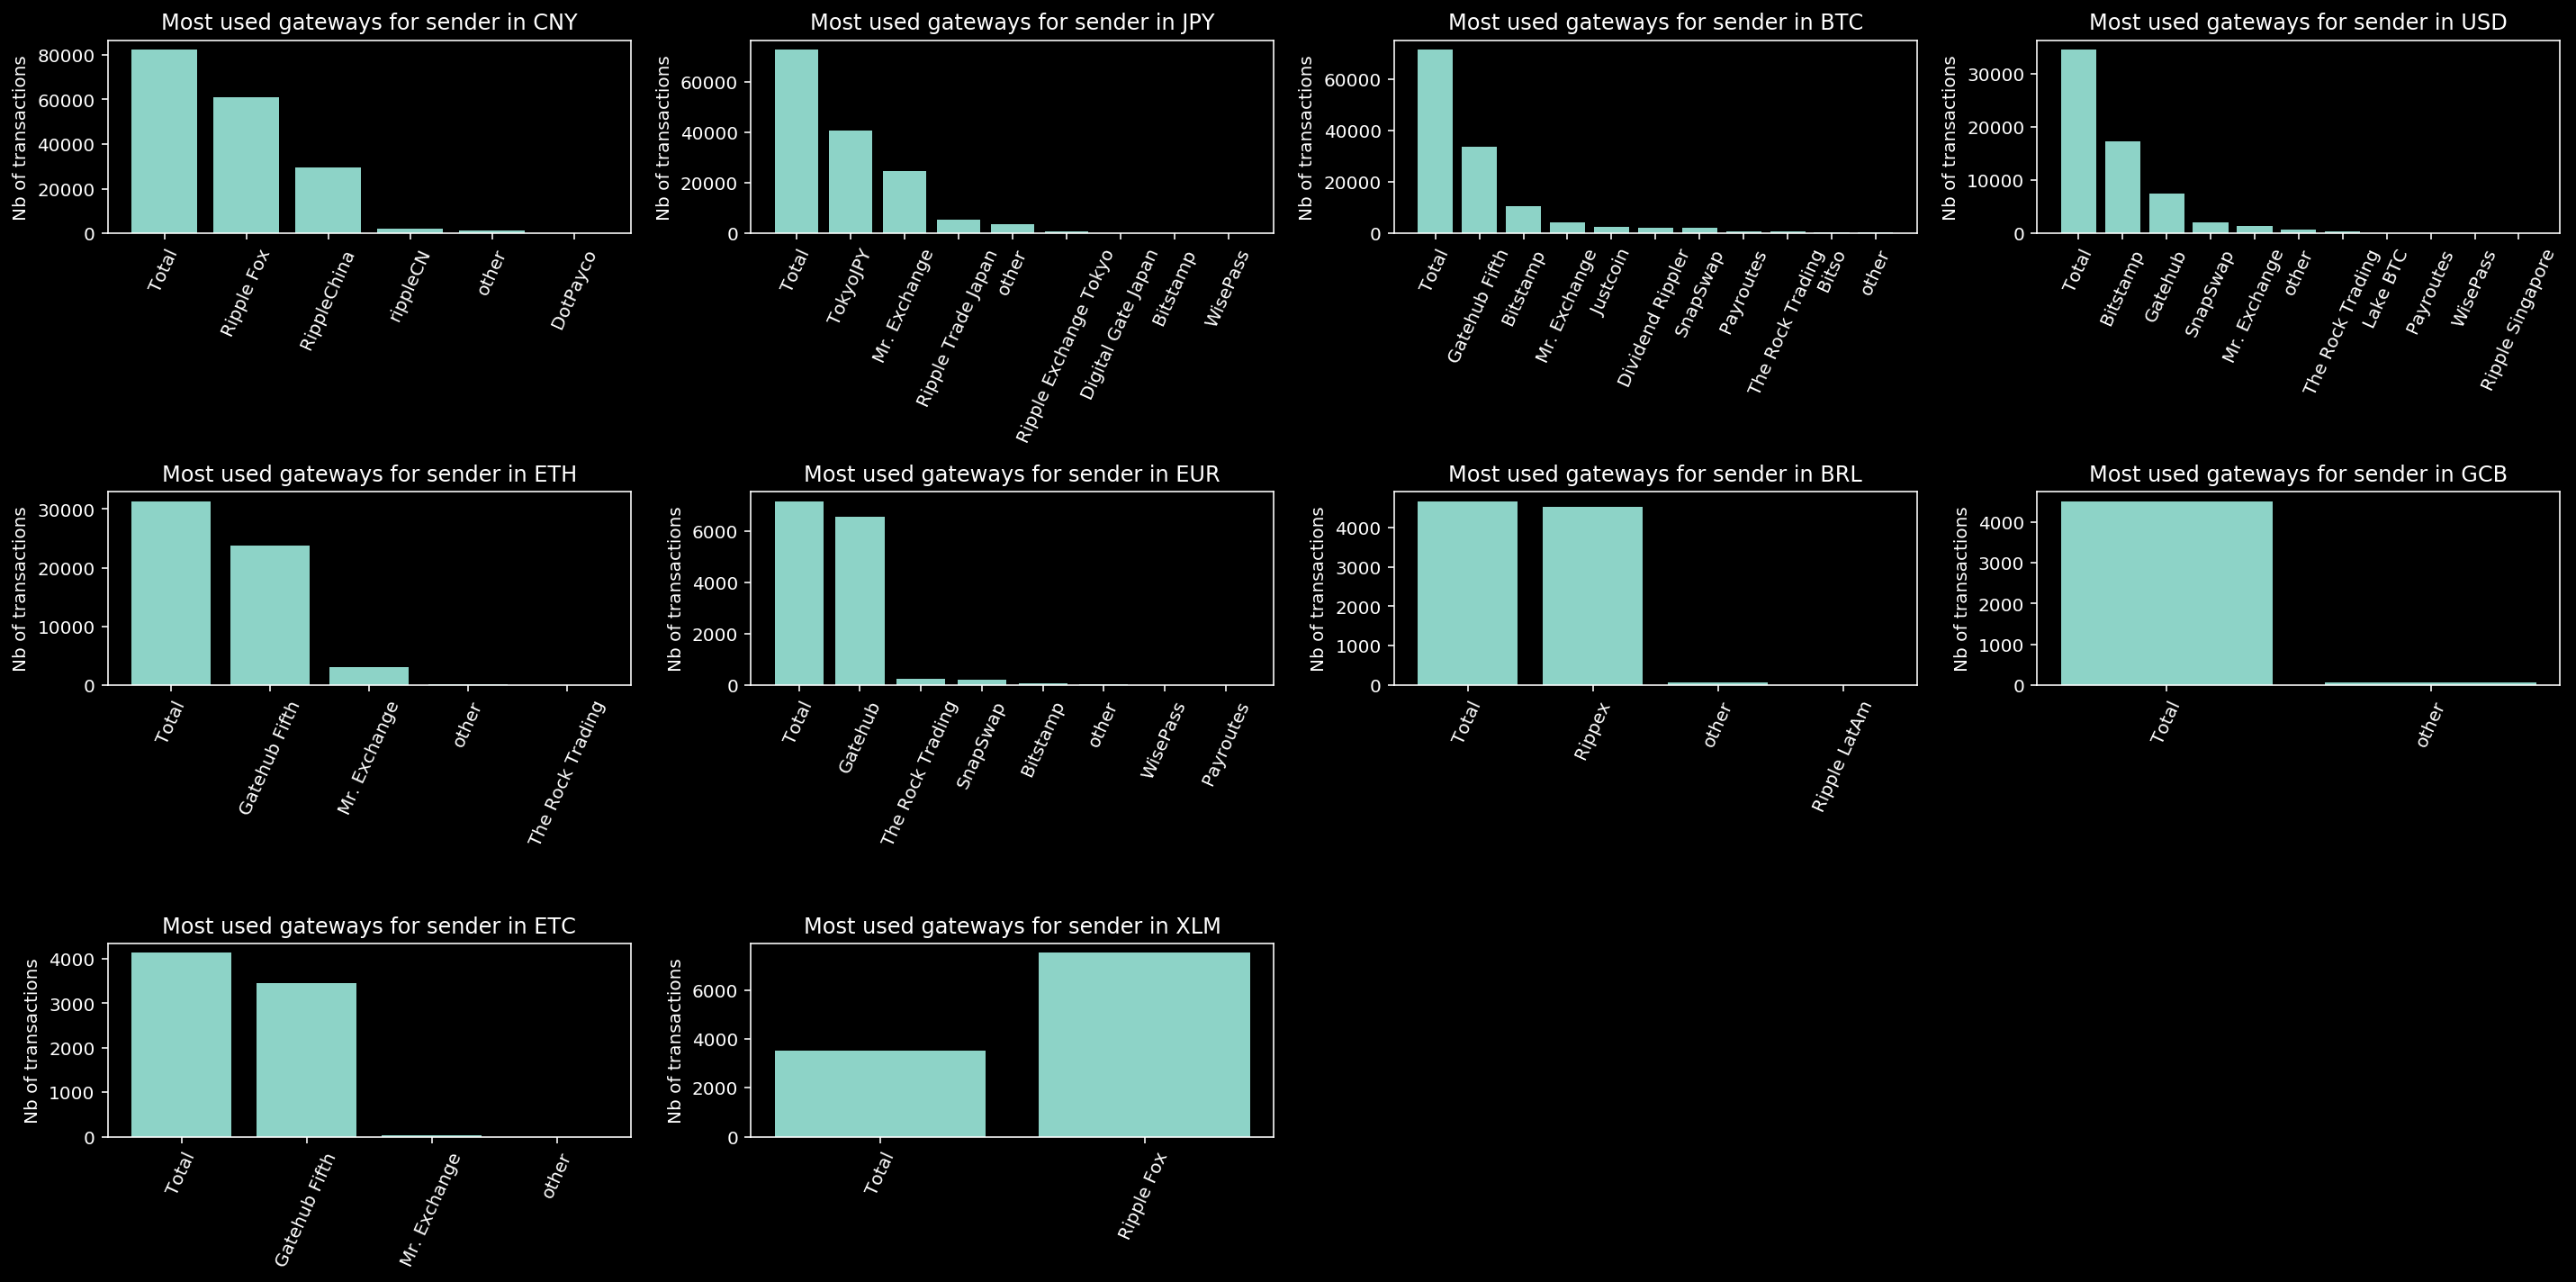

In [50]:
index = 0
plt.figure(figsize=(20,10))
for sender_currency in list(sorted_sender_currency_volume.keys()): #top 10 currencies of sender
    if (sender_currency in usage_of_trust_lines.keys()) and (index < nb_of_top_currencies):
        trust_line_usage = usage_of_trust_lines[sender_currency] #get senders_currency count (dict {currency : count})
        index+=1
        objects = list(trust_line_usage.keys())[0:nb_of_top_currencies]
        objects = ['Total'] + objects #add total nb transactions for this currency

        y_pos = np.arange(len(objects))
        performance = list(trust_line_usage.values())[0:nb_of_top_currencies]
        performance = [sorted_sender_currency_volume[sender_currency]] + performance  #add total nb transactions for this currency
    
        plt.subplot(3,4,index)
        #plt.style.use('dark_background')    
    
        plt.bar(y_pos, performance) #bar plot
        plt.xticks(y_pos, objects,rotation = 65.5)
        plt.ylabel('Nb of transactions')
        plt.title('Most used gateways for sender in ' + sender_currency)
    
plt.tight_layout()
plt.savefig('../visualisations/Gateways_usage_per_sender_currency.png')
plt.show()

Now count how many txn goes through gateways and how many does not.

In [45]:
count_through_gateways = 0
count_others = 0
for account, currencies in tqdm(usage_of_trust_lines.items()):
    for gateway,count in currencies.items():
        if gateway == 'other':
            count_others += count
        else:
            count_through_gateways += count

In [46]:
print("For wallets that have trust line with gateways in a given currency, there are in average", count_through_gateways/(count_through_gateways+count_others)*100,'% of payments in that currency made by this wallet via these trust lines with gateways') 

For wallets that have trust line with gateways in a given currency, there are in average 97.96905283894132 % of payments in that currency made by this wallet via these trust lines with gateways


### 3.3.2 Receivers

In [47]:
receiver_usage_of_trust_lines = collections.defaultdict(dict)

# For a given currency transactions checks 
# if the senders uses one of its trust lines with gateways for this currency in the transaction
#     increment the counter for the this line
# else
#     if the sender uses a trust line that is not with a gateways OR makes a direct transaction in this currency
#         increment the counter for 'others'

def get_result(txn):
    account = txn['receiver']
    if(account in wallet_to_gateway_trust_lines.keys()):
        trust_lines = wallet_to_gateway_trust_lines[account]
        #go first through the gateways 
        for trust_line in trust_lines:  
            trust_line_account = trust_line[0]
            trust_line_gateway = address_to_gateway[trust_line_account]
            trust_line_currency = trust_line[1]
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line[0] == link['node2'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line[0] == link['node1'] and trust_line_currency == link['currency'])):
                        receiver_usage_of_trust_lines[trust_line_currency] = receiver_usage_of_trust_lines.get(trust_line_currency,{})
                        receiver_usage_of_trust_lines[trust_line_currency][trust_line_gateway] = receiver_usage_of_trust_lines[trust_line_currency].get(trust_line_gateway,0) + 1
                        return
                            
        #if transaction does not go through a gateway look if it uses a other path             
        for trust_line in trust_lines:  
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line_currency == link['currency'])):
                        receiver_usage_of_trust_lines[trust_line_currency] = receiver_usage_of_trust_lines.get(trust_line_currency,{})
                        receiver_usage_of_trust_lines[trust_line_currency]['other'] =  receiver_usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                        return
                            
            #or if it's direct                  
            elif 'receiverCurrency' in txn.keys():
                if txn['receiverCurrency'] == trust_line_currency:
                    receiver_usage_of_trust_lines[trust_line_currency] = receiver_usage_of_trust_lines.get(trust_line_currency,{})
                    receiver_usage_of_trust_lines[trust_line_currency]['other'] = receiver_usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                    return
                        
#go through all transactions
for txn in tqdm(data):
    if(txn['success'] == 'tesSUCCESS'):
        get_result(txn)
        
for currency, gateway_to_volume in tqdm(receiver_usage_of_trust_lines.items()):
    receiver_usage_of_trust_lines[currency] = collections.OrderedDict(sorted(gateway_to_volume.items(),key=operator.itemgetter(1),reverse = True))

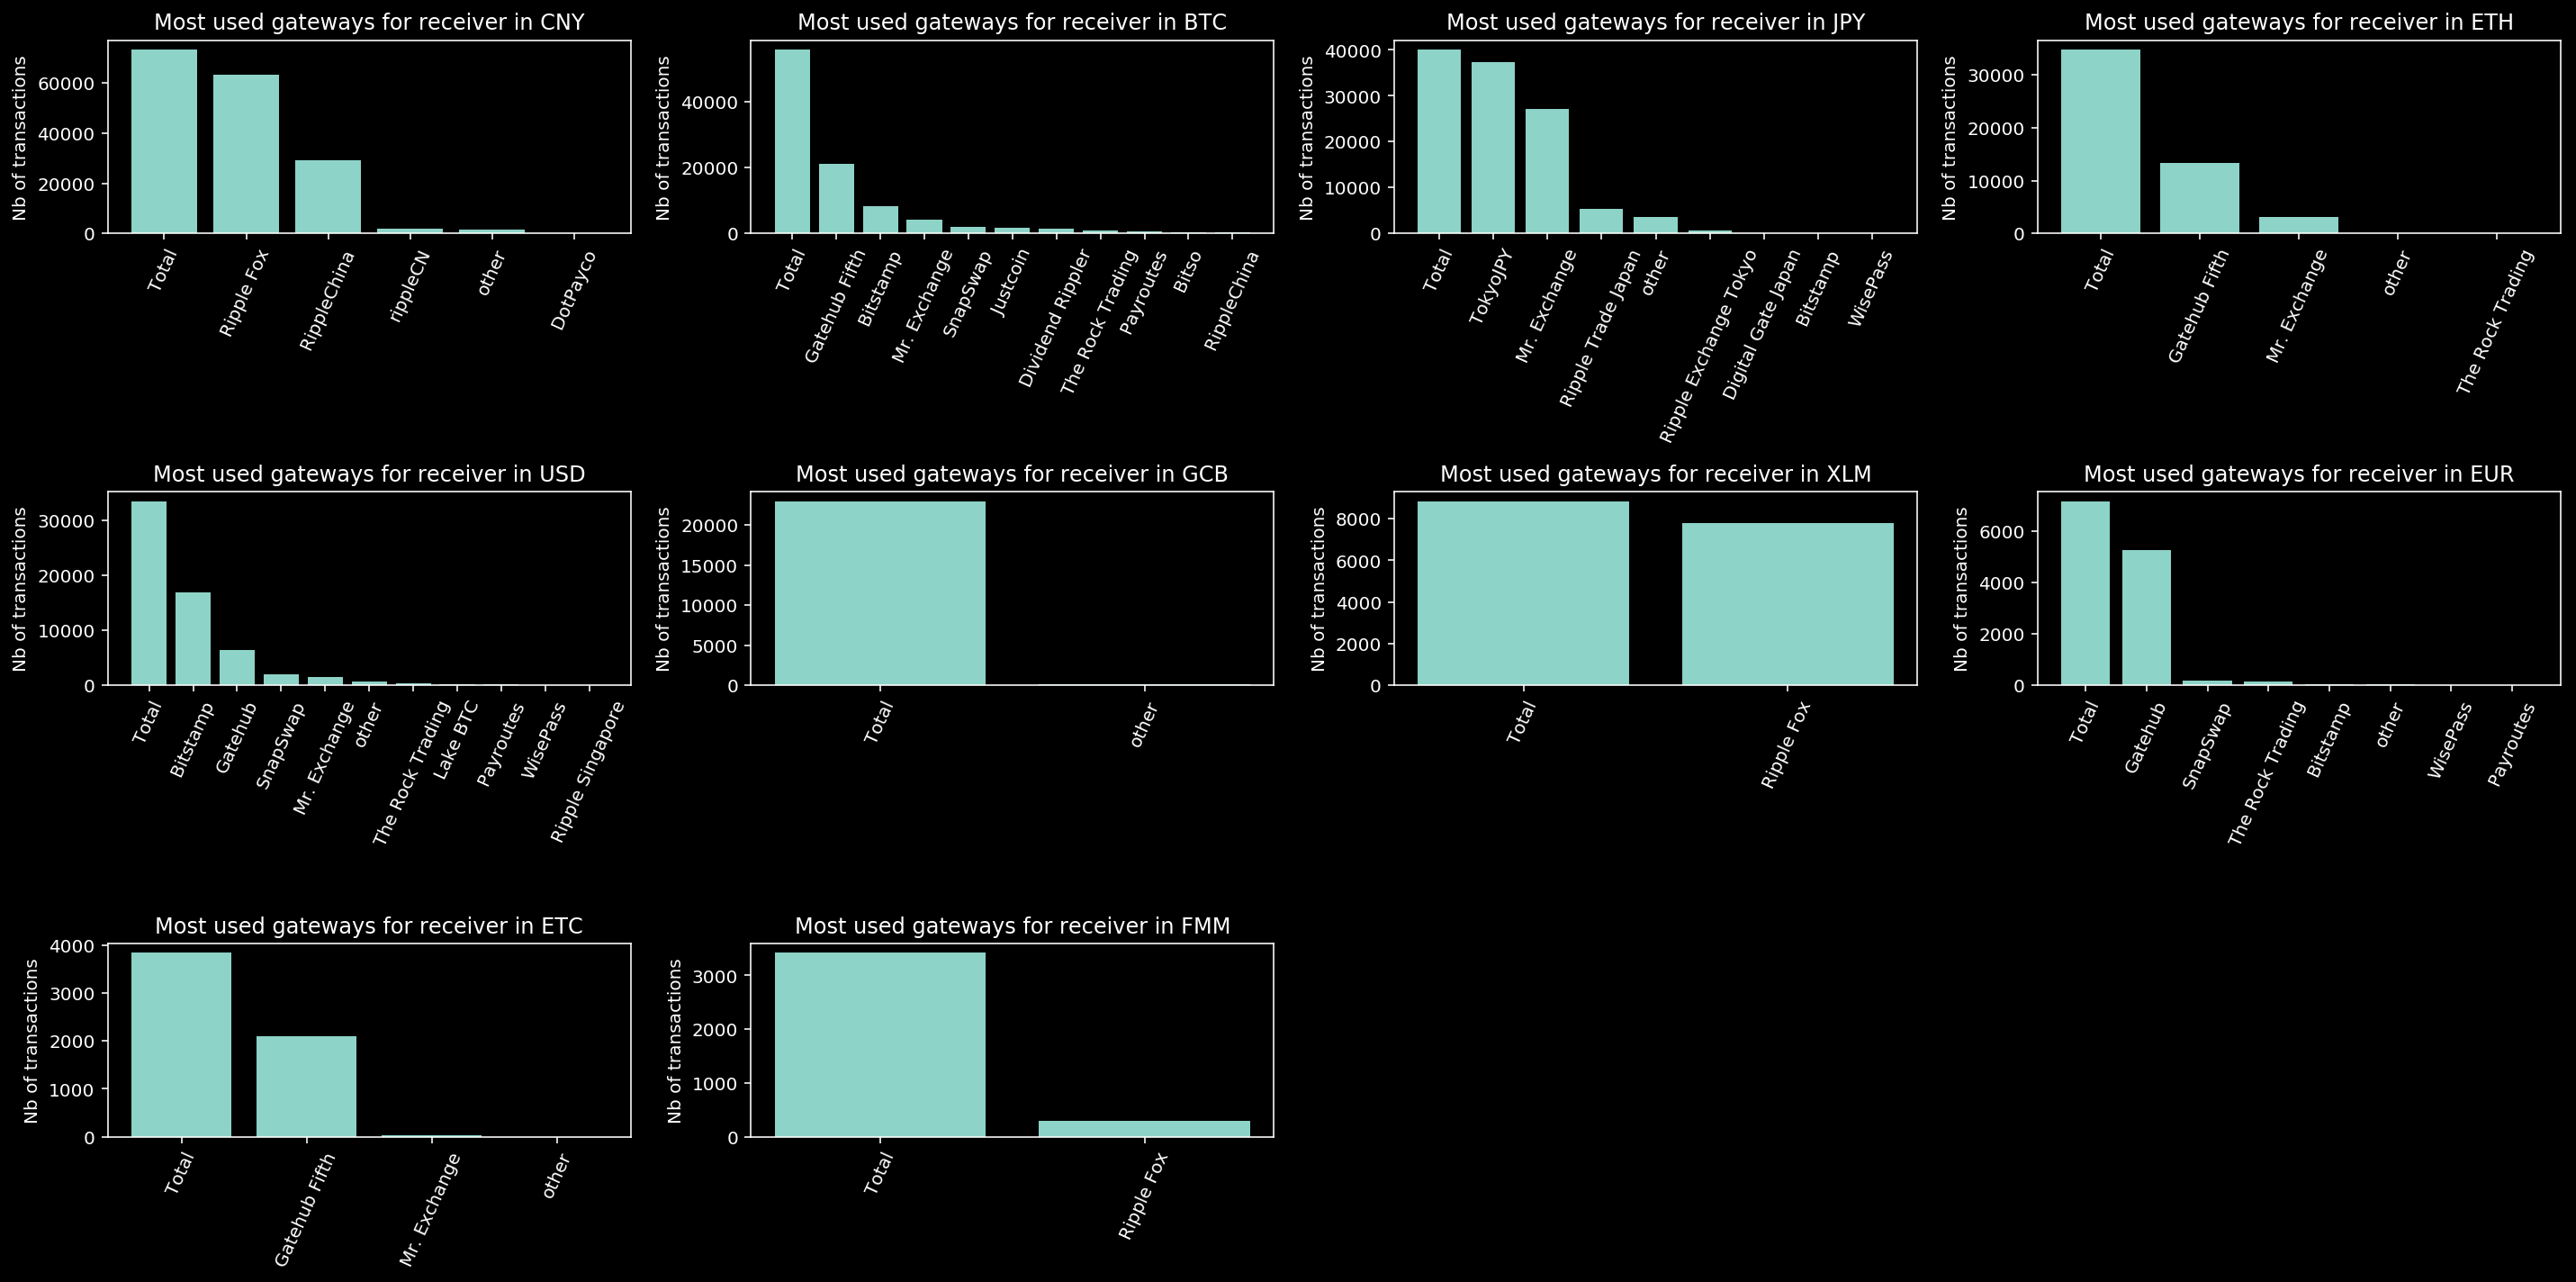

In [51]:
index = 0
plt.figure(figsize=(20,10))
for receiver_currency in list(sorted_receiver_currency_volume.keys()): #top 10 currencies of receiver
    if (receiver_currency in receiver_usage_of_trust_lines.keys()) and (index < nb_of_top_currencies):
        trust_line_usage = receiver_usage_of_trust_lines[receiver_currency] #get senders_currency count (dict {currency : count})
        index+=1
        objects = list(trust_line_usage.keys())[0:nb_of_top_currencies]
        objects = ['Total'] + objects #add total nb transactions for this currency

        y_pos = np.arange(len(objects))
        performance = list(trust_line_usage.values())[0:nb_of_top_currencies]
        performance = [sorted_receiver_currency_volume[receiver_currency]] + performance  #add total nb transactions for this currency
    
        plt.subplot(3,4,index)
        #plt.style.use('dark_background')    
    
        plt.bar(y_pos, performance) #bar plot
        plt.xticks(y_pos, objects,rotation = 65.5)
        plt.ylabel('Nb of transactions')
        plt.title('Most used gateways for receiver in ' + receiver_currency)
    
plt.tight_layout()
plt.savefig('../visualisations/Gateways_usage_per_receiver_currency.png')
plt.show()

In [319]:
count_through_gateways = 0
count_others = 0
for account, currencies in tqdm(receiver_usage_of_trust_lines.items()):
    for currency,values in currencies.items():
            if currency == 'other':
                count_others += value
            else:
                count_through_gateways += value

In [320]:
print("For wallets that have trust line with gateways in a given currency, there are in average", count_through_gateways/(count_through_gateways+count_others)*100,'% of payments in that currency made by this wallet via these trust lines with gateways') 

For wallets that have trust line with gateways in a given currency, there are in average 85.21739130434783 % of payments in that currency made by this wallet via these trust lines with gateways


# 4. Gateways

## 4.1 Gateway per currency zone

Our goal here is to find what currencies are covered by gateways and how many gateways can we find by country.

In [52]:
dict_gateways = api.get_all_gateways()

In [8]:
print("There are",len(list(dict_gateways.values())),"known gateways.")

There are 34 known gateways.


List of online gateways according to https://wipple.devnull.network/research/gateways.html

In [9]:
online_gateways = ['SnapSwap','Gatehub Fifth','Bitstamp','Payroutes','WisePass','The Rock Trading','RippleChina','DotPayco','Coinex','Ripple Fox','Lake BTC','Bitso','GBI','Gatehub','EXRP','BPG']

In [10]:
currency_to_nb_gateways = {}
for currency, gateways in tqdm(dict_gateways.items()):
    for gateway in gateways:
        if gateway['name'] in online_gateways:
            currency_to_nb_gateways[currency] = currency_to_nb_gateways.get(currency,0) + 1

In [11]:
country_to_nb_gateways= {}
for currency, nb_gateways in tqdm(currency_to_nb_gateways.items()):
    #Try to convert currency to country (only works if currency is real, ex: BTC will fail)
    try:
        currency = ccy.country(ccy.currency(currency).default_country)
        country_to_nb_gateways[currency] = nb_gateways
    except :
        continue

In [12]:
country_to_nb_gateways

{'Australia': 2,
 'Switzerland': 1,
 'Eurozone': 4,
 'Britain (UK)': 3,
 'Japan': 2,
 'United States': 8,
 'China': 3,
 'Israel': 1,
 'Norway': 1,
 'Sweden': 1,
 'Mexico': 1,
 'New Zealand': 1,
 'Korea (South)': 1}

In [13]:
gateways_address_to_name = dict()
for currency,gateways in tqdm(dict_gateways.items()):
    for gateway in gateways:
        gateway_name = gateway['name']
        gateway_account = gateway['account']
        gateways_address_to_name[gateway_account] = gateway_name

In [14]:
gateway_to_nb_txns_per_currency = collections.defaultdict(dict)

for txn in tqdm(data):
    if(txn['success'] == 'tesSUCCESS'):
        if 'links' in txn.keys():
            for link in txn['links']:
                currency_link = link['currency']
                if link['node2'] in gateways_address_to_name.keys(): #firsthop
                    gateway_name = gateways_address_to_name[link['node2']]
                    gateway_to_nb_txns_per_currency[gateway_name] = gateway_to_nb_txns_per_currency.get(gateway_name,{})
                    gateway_to_nb_txns_per_currency[gateway_name]['FirstHop'] = gateway_to_nb_txns_per_currency[gateway_name].get('FirstHop',{})
                    gateway_to_nb_txns_per_currency[gateway_name]['FirstHop'][currency_link] = gateway_to_nb_txns_per_currency[gateway_name]['FirstHop'].get(currency_link,0) + 1
                elif link['node1'] in gateways_address_to_name.keys(): #lasthop
                    gateway_name = gateways_address_to_name[link['node1']]
                    gateway_to_nb_txns_per_currency[gateway_name] = gateway_to_nb_txns_per_currency.get(gateway_name,{})
                    gateway_to_nb_txns_per_currency[gateway_name]['LastHop'] = gateway_to_nb_txns_per_currency[gateway_name].get('LastHop',{})
                    gateway_to_nb_txns_per_currency[gateway_name]['LastHop'][currency_link] = gateway_to_nb_txns_per_currency[gateway_name]['LastHop'].get(currency_link,0) + 1

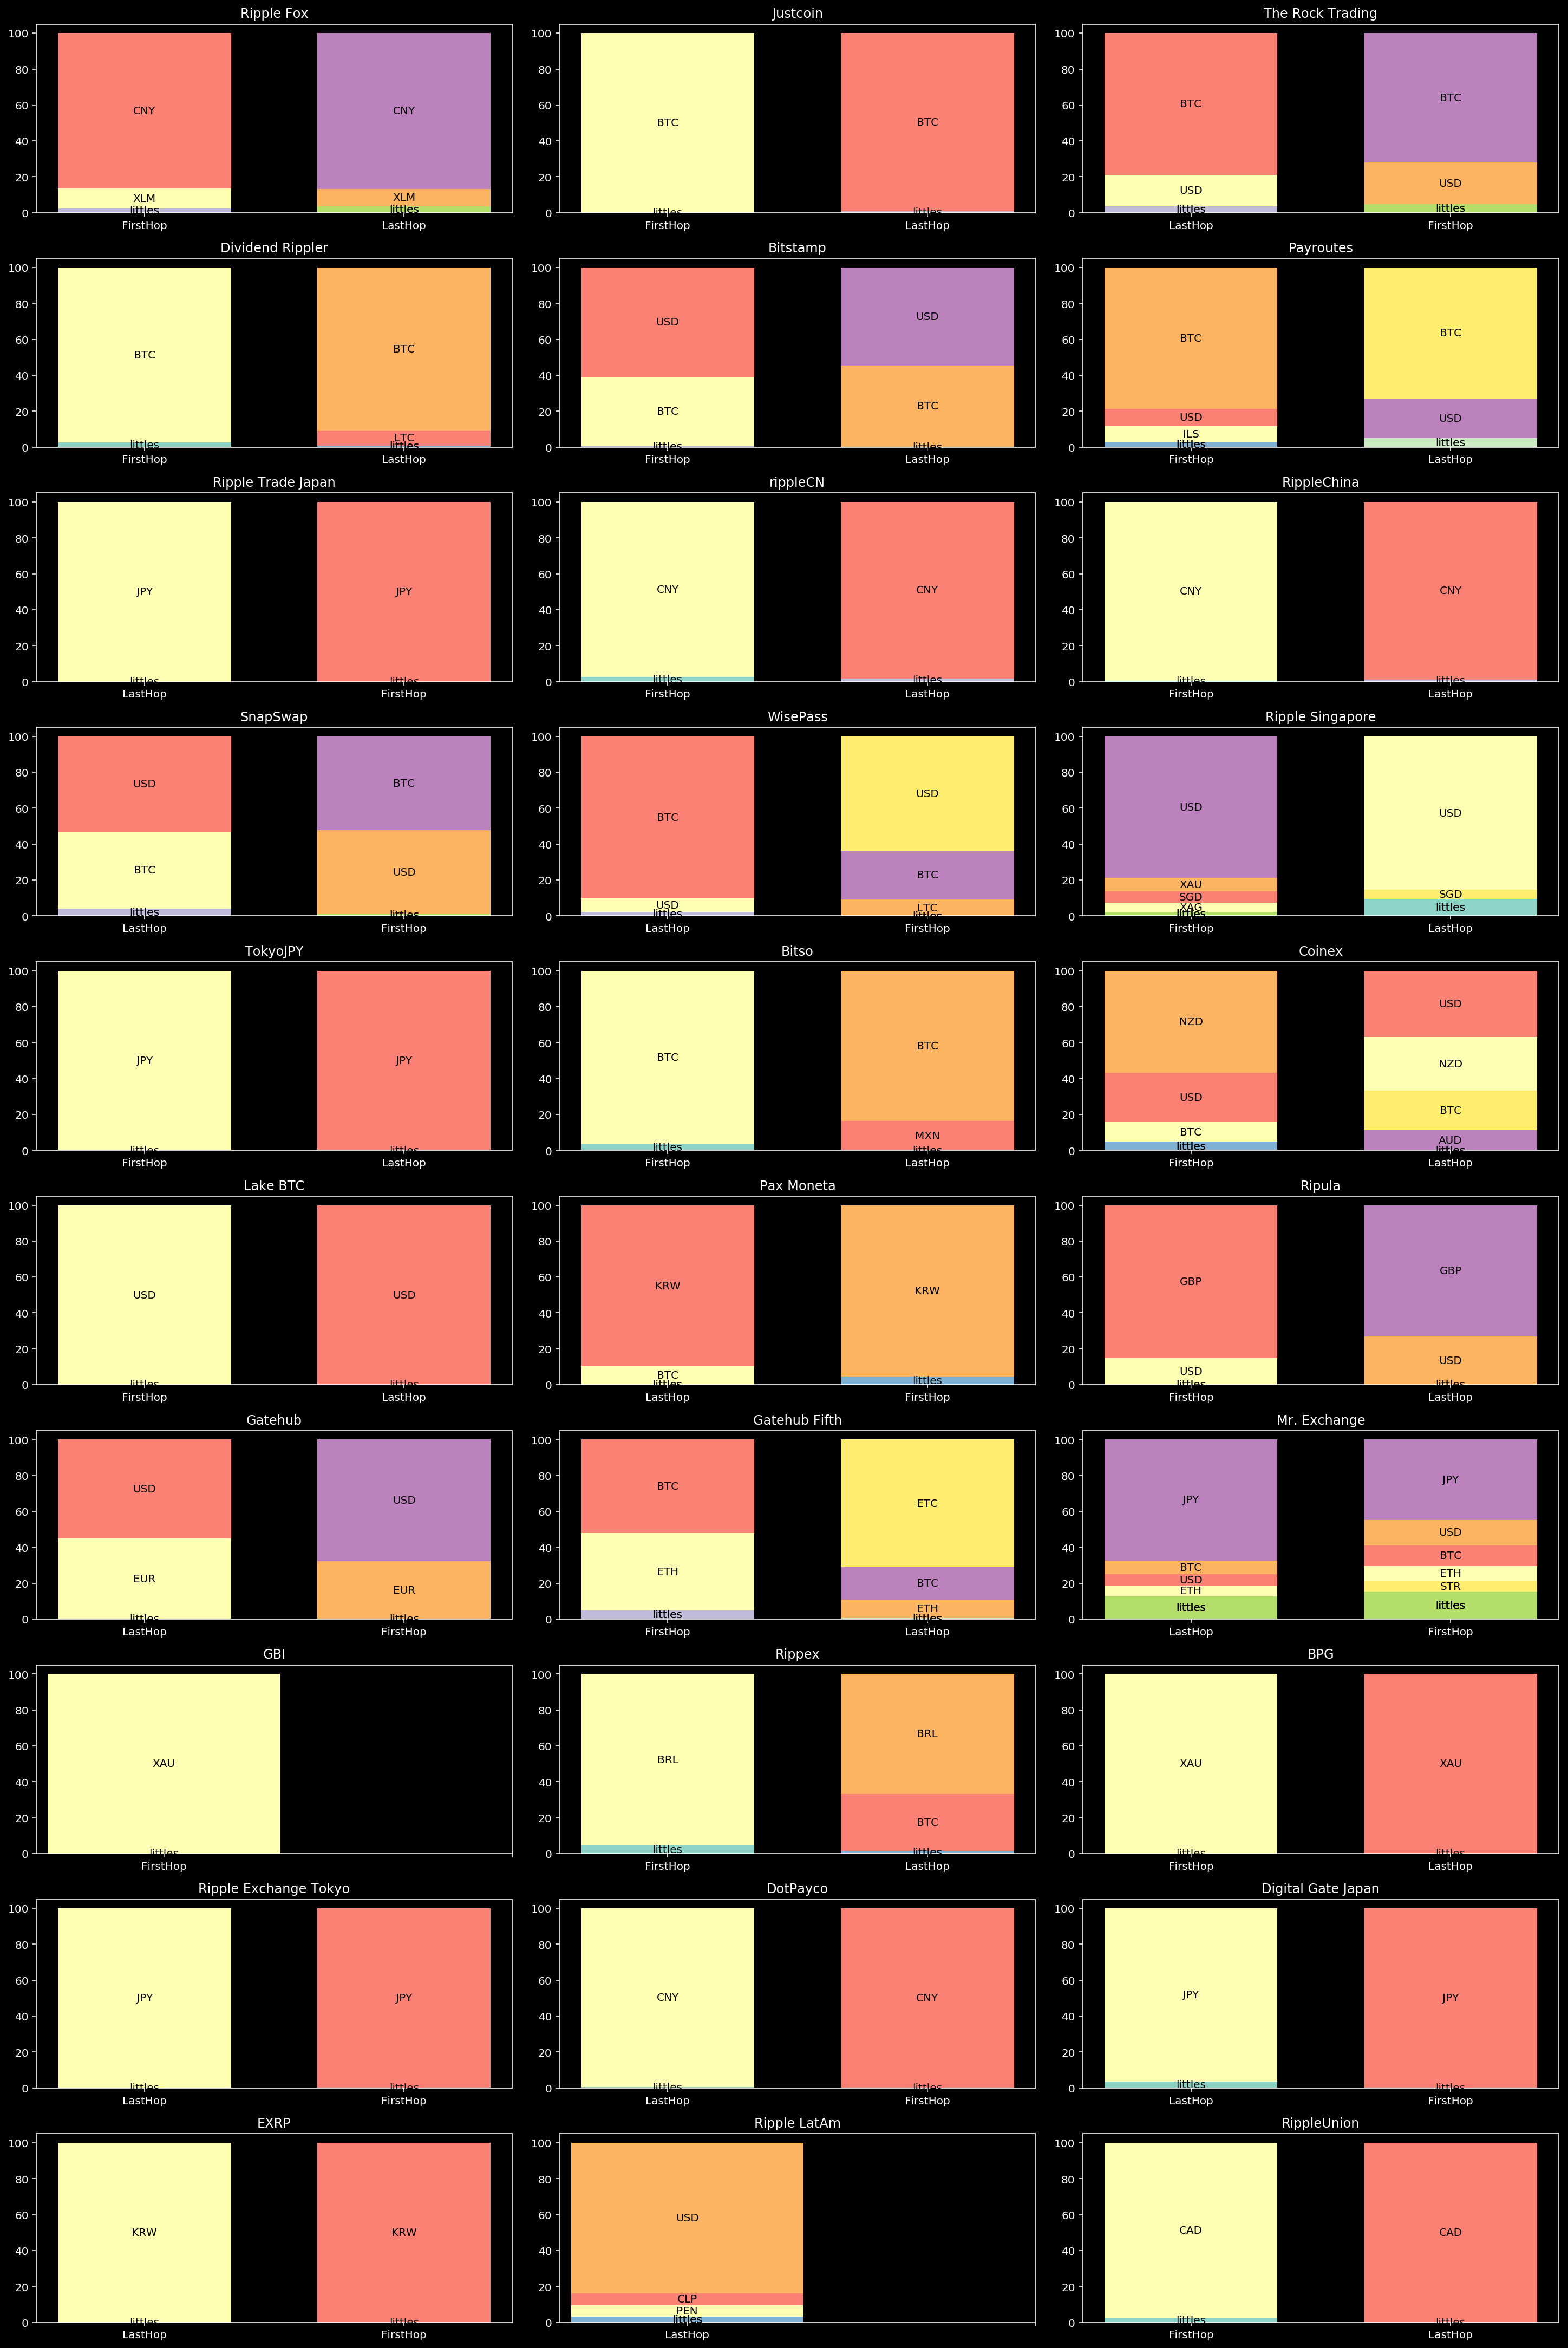

In [15]:
#plt.style.use('dark_background')    
fig, axes = plt.subplots(10, 3, constrained_layout=True,figsize=(20, 30))
for i in range(0,10):
    for j in range(0,3):
    
        test = list(gateway_to_nb_txns_per_currency.values())[3*i+j]

        w=0
        for k,v in test.items():
            sortedd = collections.OrderedDict(sorted(v.items(),key=operator.itemgetter(1),reverse = False))
            total = sum(sortedd.values())
            summ = 0
            littles = 0
            plotted_littles = False
    
            for currency,count in sortedd.items():
                bars = count/total*100
                if bars < 5:
                    littles+= bars
                else:
                    if(not plotted_littles):
                        ploted_littles = True
                        axes[i,j].bar(w,littles,width = 10)
                        axes[i,j].text(w,littles*0.5,'littles',horizontalalignment='center',verticalalignment='center',color='black')
                    axes[i,j].bar(w,bars,bottom = summ,width = 10)
                    axes[i,j].text(w,summ+bars*0.5,currency,horizontalalignment='center',verticalalignment='center',color='black')
    
                summ+= bars
            
            w+= 15
        axes[i,j].title.set_text(list(gateway_to_nb_txns_per_currency.keys())[3*i+j])
        axes[i,j].set_xticks([0,15])
        axes[i,j].set_xticklabels(list(gateway_to_nb_txns_per_currency.values())[3*i+j].keys())
fig.savefig('../visualisations/First_last_hop_currencies_per_gateways.png')            

## 4.2 Currency and gateways

In [16]:
currency_to_gateways = collections.defaultdict(dict)

for txn in tqdm(data):
    if(txn['success'] == 'tesSUCCESS'):
        if 'links' in txn.keys():
            for link in txn['links']:
                currency_link = link['currency']
                if link['node2'] in gateways_address_to_name.keys(): #firsthop
                    gateway_name = gateways_address_to_name[link['node2']]
                    currency_to_gateways[currency_link] = currency_to_gateways.get(currency_link,{})
                    currency_to_gateways[currency_link]['FirstHop'] = currency_to_gateways[currency_link].get('FirstHop',{})
                    currency_to_gateways[currency_link]['FirstHop'][gateway_name] = currency_to_gateways[currency_link]['FirstHop'].get(gateway_name,0) + 1
                elif link['node1'] in gateways_address_to_name.keys(): #lasthop
                    gateway_name = gateways_address_to_name[link['node1']]
                    currency_to_gateways[currency_link] = currency_to_gateways.get(currency_link,{})
                    currency_to_gateways[currency_link]['LastHop'] = currency_to_gateways[currency_link].get('LastHop',{})
                    currency_to_gateways[currency_link]['LastHop'][gateway_name] = currency_to_gateways[currency_link]['LastHop'].get(gateway_name,0) + 1

In [ ]:
#plt.style.use('dark_background')    
fig, axes = plt.subplots(11, 4, constrained_layout=True,figsize=(20, 30))
for i in range(0,11):
    for j in range(0,4):
        if(4*i+j < len(currency_to_gateways.keys())):
    
            test = list(currency_to_gateways.values())[4*i+j]

            w=0
            for k,v in test.items():
                sortedd = collections.OrderedDict(sorted(v.items(),key=operator.itemgetter(1),reverse = False))
                total = sum(sortedd.values())
                summ = 0
                littles = 0
                plotted_littles = False
    
                for currency,count in sortedd.items():
                    bars = count/total*100
                    if bars < 5:
                        littles+= bars
                    else:
                        if(not plotted_littles):
                            ploted_littles = True
                            axes[i,j].bar(w,littles,width = 10)
                            axes[i,j].text(w,littles*0.5,'littles',horizontalalignment='center',verticalalignment='center',color='black')
                        axes[i,j].bar(w,bars,bottom = summ,width = 10)
                        axes[i,j].text(w,summ+bars*0.5,currency,horizontalalignment='center',verticalalignment='center',color='black')
    
                    summ+= bars
            
                w+= 15
            axes[i,j].title.set_text(list(currency_to_gateways.keys())[4*i+j])
            axes[i,j].set_xticks([0,15])
            axes[i,j].set_xticklabels(list(currency_to_gateways.values())[4*i+j].keys())
fig.savefig('../visualisations/First_last_hop_gateways_per_currency.png')            

TypeError: can only concatenate str (not "ccy") to str

# 5. Nodes

In [6]:
nodes = api.get_topology()['nodes']

In [7]:
def get_country_code(ip):
    with urllib.request.urlopen("https://geoip-db.com/jsonp/"+ip) as url:
        answer = url.read().decode()[9:-1] #remove first 9 char and the last of answer to be read to convert to dict
        answer = json.loads(answer)
        return answer['country_name']

In [8]:
count = {}
for node in tqdm(nodes):
    if 'ip' in node.keys():
        country = get_country_code(node['ip'])
        count[country] = count.get(country,0) + 1

In [9]:
del count[None]

In [10]:
count = collections.OrderedDict(sorted(count.items(),key=operator.itemgetter(1),reverse = False))

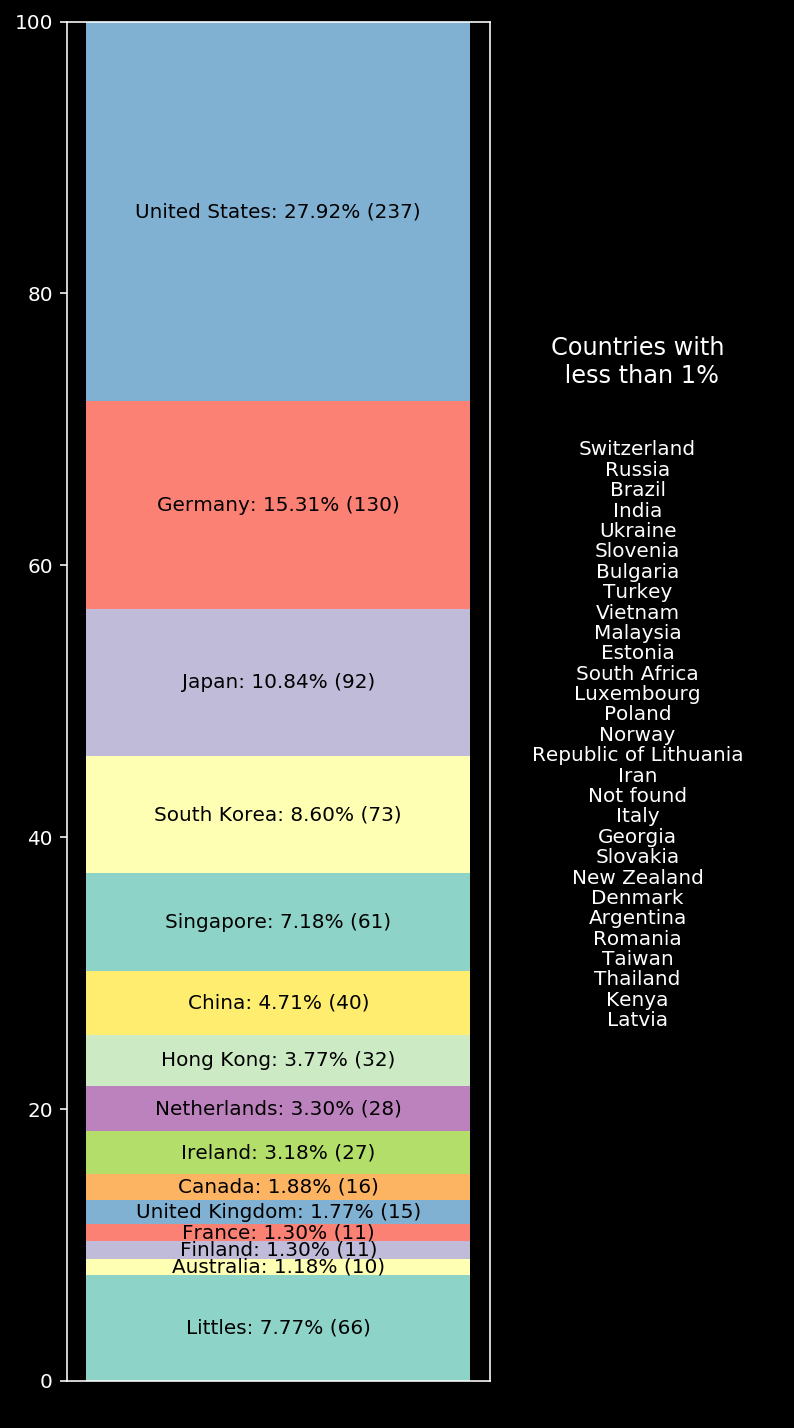

In [37]:
fig, axs = plt.subplots(1,2,figsize = (6.25,12.5),gridspec_kw={'width_ratios': [2, 1]})

total = sum(list(count.values()))
bars_previous=0
littles = 0
littles_names = []
ploted_littles = False

for k,v in tqdm(count.items()):
    bars = v/total*100
    
    if(bars < 1):
        littles+= bars
        littles_names.append(k)
   
    else:
        if(not ploted_littles):
            ploted_littles = True
            axs[0].bar(0,littles)
            axs[0].text(0,0.5*littles,'Littles: %1.2f' %littles+'% '+'(%1.0f' %(littles/100*total)+')',horizontalalignment='center',verticalalignment='center',color='black')
        axs[0].bar(0,bars,bottom = bars_previous)
        axs[0].text(0,bars_previous+0.5*bars,k+": %1.2f"% bars+'% '+'('+str(v)+')',horizontalalignment='center',verticalalignment='center',color='black')
        
    bars_previous+= bars

axs[0].set_ylim(0, 100)
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1].axis('off')
axs[1].text(0.4,0.75, 'Countries with\n less than 1%', horizontalalignment='center',verticalalignment='center',fontsize='large')
i=0
for country in littles_names:
    i+=0.015
    littles_names
    axs[1].text(0.4,0.25+i, country, horizontalalignment='center',verticalalignment='center')

#plt.style.use('dark_background')
plt.savefig('../visualisations/Repartiton_of_nodes.png')
plt.show()